In [1]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import open_clip
import numpy as np
import pandas as pd
import torchvision
import timm

Dataset : MS_CoCo 2017

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

100%|██████████| 25.0G/25.0G [11:02<00:00, 40.6MB/s]

Extracting files...


In [ ]:
import torchvision.transforms as T

Teacher: ViT-B/16

In [ ]:
device = 'cuda'
batch_size = 256 ##Done for the L4, use a smaller batch size to prep the T4

In [ ]:
import torch
import open_clip
from open_clip import get_tokenizer

# Use the verified tag for ViT-B-16 on LAION-2B
# Note the change: laion2b_s13b_b90k is for DataComp, while s34b_b88k is standard LAION
try:
    teacher, _, preprocess = open_clip.create_model_and_transforms(
        'ViT-B-16',
        pretrained='laion2b_s34b_b88k',
        device=device
    )
    print("✅ Teacher Loaded: ViT-B-16 (laion2b_s34b_b88k)")
except Exception as e:
    print(f"❌ Failed to load tag. Trying fallback 'openai'...")
    teacher, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)

teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

tokenizer_t = get_tokenizer('ViT-B-16')

Evaluation Loader for sanity checking

In [ ]:
import torchvision
from torch.utils.data import DataLoader

# 1. Load the CIFAR-10 Test Set
# We use the 'preprocess' returned by open_clip.create_model_and_transforms
# to ensure images are 224x224 and normalized correctly.
cifar_val_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=preprocess
)

# 2. Initialize the Loader
# We keep batch_size relatively high (512) for speed during zero-shot eval
cifar_loader = DataLoader(
    cifar_val_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 3. Class Names (for Zero-Shot Prompts)
# These will be passed to your tokenizer_t
cifar_classes = cifar_val_set.classes
# Standard CLIP prompt template
text_descriptions = [f"a photo of a {label}" for label in cifar_classes]

print(f"✅ CIFAR-10 Validation loaded: {len(cifar_val_set)} images.")
print(f"🏷️ Classes: {cifar_classes}")

In [ ]:
from tqdm import tqdm
def evaluate_zsi(model, loader, descriptions, tokenizer, device):
    """
    Performs Zero-Shot Inference on CIFAR-10.
    Handles both OpenCLIP Teacher (ViT) and Student (MobileViT/MobileNet).
    """
    model.eval()
    all_preds = []
    all_labels = []

    # 1. Encode Text Descriptions (The "Target Manifold")
    # This is only done once per evaluation to save compute
    print(f"   💬 Tokenizing and encoding {len(descriptions)} class descriptions...")
    with torch.no_grad():
        text_tokens = tokenizer(descriptions).to(device)

        # Check if model is OpenCLIP or custom Student
        if hasattr(model, 'encode_text'):
            text_features = model.encode_text(text_tokens)
        else:
            # For your student model which likely returns (v, t, logit_scale)
            # We only need the text branch here.
            _, text_features, _ = model(None, text_tokens, mode='text_only')

        text_features /= text_features.norm(dim=-1, keepdim=True)

    # 2. Image Inference Loop
    print(f"   📸 Running image inference (Batch Size: {loader.batch_size})...")
    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs = imgs.to(device)

            # Encode Image Branch
            if hasattr(model, 'encode_image'):
                image_features = model.encode_image(imgs)
            else:
                # Student model forward pass
                image_features, _, _ = model(imgs, None, mode='image_only')

            image_features /= image_features.norm(dim=-1, keepdim=True)

            # 3. Calculate Similarity and Predict
            # CLIP standard uses a temperature of 100 (logit_scale)
            logits = (100.0 * image_features @ text_features.T)
            preds = logits.argmax(dim=-1)

            all_preds.append(preds.cpu())
            all_labels.append(labels)

    # 4. Final Metric Calculation
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)
    accuracy = (y_pred == y_true).float().mean().item()

    return accuracy

acc = evaluate_zsi(teacher, cifar_loader, text_descriptions, tokenizer_t, device)
print(f"⭐ ZSI Accuracy: {acc*100:.2f}%")

Load in Dataset

In [ ]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. Path Configuration
# Standard Kaggle path for the COCO 2017 dataset
coco_root = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
coco_annFile = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'

# 2. Dataset Initialization
# We use the 'preprocess' from your OpenCLIP teacher to ensure
# the student sees the exact same image distribution.
dataset_coco = dset.CocoCaptions(
    root=coco_root,
    annFile=coco_annFile,
    transform=preprocess  # Inherited from your Teacher initialization
)

# 3. Custom Collate Function
# COCO returns multiple captions per image. For CLIP distillation,
# we randomly select ONE caption per image to keep the batch balanced.
def coco_collate_fn(batch):
    images, captions = zip(*batch)
    # Randomly pick one caption from the list of 5 for each image
    selected_captions = [c[torch.randint(0, len(c), (1,)).item()] for c in captions]

    # Tokenize the selected captions using your OpenCLIP tokenizer
    tokens = tokenizer_t(selected_captions)

    return torch.stack(images), tokens

# 4. Loader Initialization (Standardized to 128 for L4)
loader_start = DataLoader(
    dataset_coco,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=coco_collate_fn
)

print(f"📦 Dataset 'dataset_coco' initialized with {len(dataset_coco)} samples.")
print(f"🚀 'loader_start' ready with Batch Size: 128")

In [11]:
import torch
import numpy as np
import os
from tqdm import tqdm

# 1. Path Setup
# Standard Kaggle output directory for your feature bank
save_path = "/kaggle/working/coco_feature_bank"
os.makedirs(save_path, exist_ok=True)

def generate_synchronized_embeddings(model, loader, device, save_dir):
    """
    Extracts and saves teacher embeddings in the exact order of the dataset.
    """
    model.to(device)
    model.eval()

    img_embeds_list = []
    txt_embeds_list = []

    print(f"🚀 Starting Feature Extraction for {len(loader.dataset)} samples...")

    with torch.no_grad():
        # IMPORTANT: Ensure loader has shuffle=False to maintain dataset order
        for images, tokens in tqdm(loader, desc="   Extracting Features"):
            images = images.to(device)
            tokens = tokens.to(device)

            # 1. Forward Pass through Teacher
            # OpenCLIP specifically uses these methods
            t_v = model.encode_image(images)
            t_t = model.encode_text(tokens)

            # 3. Store as CPU numpy arrays to save VRAM
            img_embeds_list.append(t_v.cpu().numpy())
            txt_embeds_list.append(t_t.cpu().numpy())

    # 4. Consolidate and Save
    print("💾 Saving synchronized embeddings to Drive/Kaggle...")

    # Save as .npy for fast loading into your new dataset class
    final_v = np.concatenate(img_embeds_list, axis=0)
    final_t = np.concatenate(txt_embeds_list, axis=0)

    np.save(os.path.join(save_dir, 'teacher_vision_features.npy'), final_v)
    np.save(os.path.join(save_dir, 'teacher_text_features.npy'), final_t)

    print(f"✅ Extraction Complete! Saved {len(final_v)} synchronized pairs.")
    return final_v, final_t

# --- EXECUTION ---
# Ensure your loader_start has shuffle=False before running this!
teacher_vision, teacher_text = generate_synchronized_embeddings(teacher, loader_start, device, save_path)

🚀 Starting Feature Extraction for 118287 samples...


   Extracting Features: 100%|██████████| 925/925 [08:16<00:00,  1.86it/s]


💾 Saving synchronized embeddings to Drive/Kaggle...
✅ Extraction Complete! Saved 118287 synchronized pairs.


In [12]:
import torch
import numpy as np

def compute_zca_stats(features):
    # 1. Compute Mean and center the data
    mu = np.mean(features, axis=0)
    centered = features - mu

    # 2. Compute Covariance Matrix (unbiased)
    n_samples = features.shape[0]
    covariance = (centered.T @ centered) / (n_samples - 1)

    # 3. SVD for ZCA Whitening
    U, S, Vh = np.linalg.svd(covariance)
    epsilon = 1e-5 # For numerical stability

    # 4. ZCA Whitening Matrix: W = U * diag(1/sqrt(S + eps)) * U.T
    W = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T

    return torch.from_numpy(mu).float().cuda(), torch.from_numpy(W).float().cuda()

# --- EXECUTION ---
print("⚙️ Computing Separate Whitening Stats...")
mu_img, W_img = compute_zca_stats(teacher_vision)
mu_txt, W_txt = compute_zca_stats(teacher_text)
print("✅ Stats Ready.")

⚙️ Computing Separate Whitening Stats...
✅ Stats Ready.


In [13]:
import torch.nn.functional as F

@torch.no_grad()
def sanity_check_whitened_teacher(model, loader, tokenizer, mu_img, W_img, mu_txt, W_txt):
    model.eval()
    device = next(model.parameters()).device

    # 1. Prepare Text Classifier
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    prompts = [f"a photo of a {name}" for name in class_names]
    tokens = tokenizer(prompts).to(device)

    # Get raw teacher text features and whiten
    t_txt = model.encode_text(tokens)
    t_txt = (t_txt - mu_txt) @ W_txt
    t_txt = F.normalize(t_txt, p=2, dim=-1) # Project back to sphere

    correct, total = 0, 0
    for images, labels in tqdm(loader, desc="🔍 Sanity Check"):
        images, labels = images.to(device), labels.to(device)

        # Get raw teacher image features and whiten
        t_img = model.encode_image(images)
        t_img = (t_img - mu_img) @ W_img
        t_img = F.normalize(t_img, p=2, dim=-1) # Project back to sphere

        # Calculate Similarity
        logits = t_img @ t_txt.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return (correct / total) * 100

# --- EXECUTION ---
# Ensure your cifar_loader is defined using teacher.preprocess
test_acc = sanity_check_whitened_teacher(teacher, cifar_loader, tokenizer_t, mu_img, W_img, mu_txt, W_txt)
print(f"\n✅ Whitened Teacher CIFAR-10 Accuracy: {test_acc:.2f}%")

🔍 Sanity Check: 100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


✅ Whitened Teacher CIFAR-10 Accuracy: 63.85%


In [14]:
import torch
import numpy as np
from torch.utils.data import Dataset

class CLIPDistillDataset(Dataset):
    def __init__(self, base_dataset):
        """
        Args:
            base_dataset: The original dataset_coco (CocoCaptions)
            vision_path: Path to 'teacher_vision_features.npy'
            text_path: Path to 'teacher_text_features.npy'
        """
        self.base_dataset = base_dataset

        # Load the pre-computed embeddings

        self.teacher_vision = teacher_vision
        self.teacher_text = teacher_text

        # Sanity check: lengths must match
        assert len(self.base_dataset) == len(self.teacher_vision) == len(self.teacher_text), \
            "❌ Index mismatch! Dataset and embeddings must have the same length."

        print(f"✅ Student Dataset ready with {len(self.teacher_vision)} samples.")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # 1. Get raw image and all captions from base COCO
        image, captions = self.base_dataset[idx]

        # 2. Get the corresponding pre-computed teacher features
        t_v = torch.from_numpy(self.teacher_vision[idx]).float()
        t_t = torch.from_numpy(self.teacher_text[idx]).float()

        # Note: Since the embeddings were generated with a fixed caption per image
        # during the 'generate_synchronized_embeddings' pass, we return the
        # base data and the target embeddings.
        return image, captions, t_v, t_t

# --- Initialization ---
# Assuming files were saved to /kaggle/working/coco_feature_bank
student_dataset = CLIPDistillDataset(
    base_dataset=dataset_coco
)

✅ Student Dataset ready with 118287 samples.


In [15]:
def student_collate_fn(batch):
    images, all_captions, t_vs, t_ts = zip(*batch)

    # 1. Handle Text: Pick ONE caption per image (same as we did for Teacher)
    # We must tokenize them here so the student gets a [128, 77] tensor
    selected_captions = [c[0] for c in all_captions] # Using index 0 for consistency
    tokens = tokenizer_t(selected_captions)

    # 2. Stack everything into tensors
    return (
        torch.stack(images),
        tokens,
        torch.stack(t_vs),
        torch.stack(t_ts)
    )

# The optimized loader for your L4
student_loader = DataLoader(
    student_dataset,
    batch_size=128,
    shuffle=True,      # Safe to shuffle now because the embeddings are already matched!
    num_workers=4,
    pin_memory=True,
    collate_fn=student_collate_fn
)

In [18]:
import shutil
import os
from google.colab import drive

# 1. Mount Google Drive
# This will prompt you for authorization.
drive.mount('/content/drive')

# 2. Define Source and Destination
# Source: Your Kaggle working directory
# Destination: A specific folder in your Drive (e.g., 'Distillation_Project')
source_folder = '/kaggle/working/coco_feature_bank'
drive_destination = '/content/drive/MyDrive/CLIP_Proj_Dec24/coco_features'

# Create the folder in Drive if it doesn't exist
os.makedirs(drive_destination, exist_ok=True)

# 3. Transfer the Files
print(f"🚛 Transferring features to: {drive_destination}...")

files_to_move = ['teacher_vision_features.npy', 'teacher_text_features.npy']

for f in files_to_move:
    src = os.path.join(source_folder, f)
    dst = os.path.join(drive_destination, f)

    if os.path.exists(src):
        print(f"   Moving {f}...")
        shutil.copy(src, dst)
        print(f"   ✅ Done: {f}")
    else:
        print(f"   ❌ Error: {f} not found in source!")

print("\n🎉 All features safely backed up to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚛 Transferring features to: /content/drive/MyDrive/CLIP_Proj_Dec24/coco_features...
   Moving teacher_vision_features.npy...
   ✅ Done: teacher_vision_features.npy
   Moving teacher_text_features.npy...
   ✅ Done: teacher_text_features.npy

🎉 All features safely backed up to Google Drive.


Student Setup : Using MobileViT

In [23]:
import torch
import torch.nn as nn
import timm
import numpy as np

class MobileViTCLIP(nn.Module):
    def __init__(self, internal_dim=384, output_dim=512, transformer_layers=12, nhead=6):
        super().__init__()

        # --- 1. Vision Branch (Backbone) ---
        # Output: [Batch, 640]
        self.visual = timm.create_model('mobilevit_s', pretrained=True, num_classes=0)

        # --- 2. Integrated Projection Head (Targeting 512 directly) ---
        # 640 (Backbone) -> 1024 (Capacity) -> 512 (CLIP Space)
        self.visual_proj = nn.Sequential(
            nn.Linear(640, 1024),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, output_dim) # Direct to 512
        )

        # --- 3. Text Branch ---
        vocab_size = 49408
        self.token_embedding = nn.Embedding(vocab_size, internal_dim)
        self.positional_embedding = nn.Parameter(torch.empty(77, internal_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=internal_dim,
            nhead=nhead,
            dim_feedforward=internal_dim * 4,
            batch_first=True,
            activation='gelu',
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)
        self.ln_final = nn.LayerNorm(internal_dim)

        # Project Internal (384) -> Output (512)
        self.text_projection = nn.Parameter(torch.empty(internal_dim, output_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        # Weight Init
        nn.init.normal_(self.positional_embedding, std=0.01)
        nn.init.normal_(self.text_projection, std=0.02)
        nn.init.kaiming_normal_(self.visual_proj[0].weight, mode='fan_out', nonlinearity='relu')
        nn.init.normal_(self.visual_proj[3].weight, std=0.01)

    def forward(self, images=None, texts=None):
        v_feat_raw, v_embed, t_embed = None, None, None

        # --- Vision Forward ---
        if images is not None:
            v_feat_raw = self.visual(images) # [Batch, 640]

            # Project directly to 512
            v_embed = self.visual_proj(v_feat_raw)
            v_embed = v_embed / v_embed.norm(dim=-1, keepdim=True)

        # --- Text Forward ---
        if texts is not None:
            x = self.token_embedding(texts) + self.positional_embedding
            x = self.transformer(x)
            x = self.ln_final(x)
            x = x[torch.arange(x.shape[0]), texts.argmax(dim=-1)]

            # Project directly to 512
            t_embed = x @ self.text_projection
            t_embed = t_embed / t_embed.norm(dim=-1, keepdim=True)

        # Return 4 items matches ResNet loop: (Raw, Visual_512, Text_512, Scale)
        return v_embed, t_embed, self.logit_scale.exp()

# --- RE-INITIALIZATION & SYNC ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🚀 Instantiating Fixed MobileViTCLIP (Direct 512 Output)...")
student_mvit = MobileViTCLIP(internal_dim=384, output_dim=512).to(device)

def initialize_mobile_weights(student_model, teacher_model):
    """
    Slices teacher weights.
    Student Internal: 384
    Student Output: 512
    Teacher: 512 -> 512
    """
    s_int = 384
    with torch.no_grad():
        # 1. Embeddings: Slice [Vocab, 512] -> [Vocab, 384]
        student_model.token_embedding.weight.copy_(
            teacher_model.token_embedding.weight.data[:, :s_int]
        )
        student_model.positional_embedding.copy_(
            teacher_model.positional_embedding.data[:, :s_int]
        )

        # 2. Projection: Slice ROWS only [384, 512]
        # We take the top 384 dimensions of the teacher's input space,
        # but keep the full 512 output dimensions so it matches the teacher's space.
        student_model.text_projection.copy_(
            teacher_model.text_projection.data[:s_int, :]
        )

        # 3. Scale
        student_model.logit_scale.copy_(teacher_model.logit_scale.data)

    return student_model

student_mvit = initialize_mobile_weights(student_mvit, teacher)
print("✅ Model Ready. Output dim is now Natively 512.")

🚀 Instantiating Fixed MobileViTCLIP (Direct 512 Output)...
✅ Model Ready. Output dim is now Natively 512.


In [24]:
import copy
import torch

# --- 1. Instantiate the Master MobileViT Student ---
print("🚀 Instantiating Master MobileViT Student (Output: 512)...")
# Note: Using the updated signature (internal=384, output=512)
master_student_mvit = MobileViTCLIP(internal_dim=384, output_dim=512, transformer_layers=12, nhead=6).to(device)

# --- 2. Surgical Weight Slicing (Sync with Teacher) ---
print("🔪 Performing Surgical Weight Slicing...")
with torch.no_grad():
    # 1. Sync Logit Scale (Temperature)
    master_student_mvit.logit_scale.copy_(teacher.logit_scale)

    # 2. Slice Token Embeddings [Vocab, 512] -> [Vocab, 384]
    # We take the first 384 dimensions of each word embedding
    master_student_mvit.token_embedding.weight.copy_(
        teacher.token_embedding.weight.data[:, :384]
    )

    # 3. Slice Positional Embeddings [77, 512] -> [77, 384]
    master_student_mvit.positional_embedding.copy_(
        teacher.positional_embedding.data[:, :384]
    )

    # 4. Slice Text Projection [512, 512] -> [384, 512]
    # CRITICAL FIX: We take the first 384 rows (inputs) but keep ALL 512 columns (outputs).
    # This allows the 384-dim student to project directly into the 512-dim Teacher Space.
    master_student_mvit.text_projection.copy_(
        teacher.text_projection.data[:384, :]
    )

print(f"✅ Master Initialized. Scale: {master_student_mvit.logit_scale.exp().item():.3f}")

# --- 3. Clone into 6 Identical Students ---
print("👯 Cloning 6 Identical MobileViT Students...")

# Group A: Structure (ICL)
student_icl_white = copy.deepcopy(master_student_mvit)
student_icl_raw   = copy.deepcopy(master_student_mvit)

# Group B: Content (FD)
student_fd_white  = copy.deepcopy(master_student_mvit)
student_fd_raw    = copy.deepcopy(master_student_mvit)

# Group C: Synergy (Full)
student_white     = copy.deepcopy(master_student_mvit) # Proposed Method (Ours)
student           = copy.deepcopy(master_student_mvit) # Baseline (Raw)

# Verify Independence (Sanity Check)
assert student_white is not student
# Check that deep copy worked on the new sequential head
assert student_white.visual_proj[0].weight is not student.visual_proj[0].weight

print("✅ All 6 MobileViT Students are ready for the Grand Ablation.")
print("   Names: student_icl_white, student_icl_raw, student_fd_white, student_fd_raw, student_white, student")

🚀 Instantiating Master MobileViT Student (Output: 512)...
🔪 Performing Surgical Weight Slicing...
✅ Master Initialized. Scale: 100.000
👯 Cloning 6 Identical MobileViT Students...
✅ All 6 MobileViT Students are ready for the Grand Ablation.
   Names: student_icl_white, student_icl_raw, student_fd_white, student_fd_raw, student_white, student


In [25]:
def loss_icl_complete(s_v, s_t, t_v, t_t, logit_scale, alpha=2000.0):
    """
    Unified Loss Function: InfoNCE + Feature Distillation + Inter-Coordinate Loss
    All embeddings (Student and Teacher) must be normalized before passing here.
    """
    labels = torch.arange(len(s_v), device=s_v.device)

    # --- 1. InfoNCE (Student Internal Alignment) ---
    # Can the student align its own images to its own text?
    logits_st = logit_scale * s_v @ s_t.t()
    loss_infonce = (F.cross_entropy(logits_st, labels) +
                    F.cross_entropy(logits_st.t(), labels)) / 2

    # --- 2. FD (Feature Distillation) ---
    # Force student embeddings to match teacher embeddings directly (MSE)
    # Using 's_v' directly implies it has the same dimension as 't_v' (512)
    loss_fd = (F.mse_loss(s_v, t_v) + F.mse_loss(s_t, t_t)) * alpha

    # --- 3. ICL (Inter-Coordinate Loss / Cross-Modal Distillation) ---
    # Can student embeddings find the Teacher's targets?
    # Relationship 1: Student Image -> Teacher Text
    logits_sv_tt = logit_scale * s_v @ t_t.t()
    # Relationship 2: Student Text -> Teacher Image
    logits_st_tv = logit_scale * s_t @ t_v.t()

    loss_icl = (F.cross_entropy(logits_sv_tt, labels) +
                F.cross_entropy(logits_st_tv, labels)) / 2

    # Return total and individual components
    return loss_infonce + loss_fd + loss_icl, loss_infonce, loss_fd, loss_icl

In [43]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 0. The Loss Function ---
def loss_icl_complete(s_v, s_t, t_v, t_t, logit_scale, alpha=2000.0):
    """
    Unified Loss Function: InfoNCE + Feature Distillation + Inter-Coordinate Loss
    All embeddings (Student and Teacher) must be normalized before passing here.
    """
    labels = torch.arange(len(s_v), device=s_v.device)

    # --- 1. InfoNCE (Student Internal Alignment) ---
    logits_st = logit_scale * s_v @ s_t.t()
    loss_infonce = (F.cross_entropy(logits_st, labels) +
                    F.cross_entropy(logits_st.t(), labels)) / 2

    # --- 2. FD (Feature Distillation) ---
    loss_fd = (F.mse_loss(s_v, t_v) + F.mse_loss(s_t, t_t)) * alpha

    # --- 3. ICL (Inter-Coordinate Loss / Cross-Modal Distillation) ---
    logits_sv_tt = logit_scale * s_v @ t_t.t()
    logits_st_tv = logit_scale * s_t @ t_v.t()

    loss_icl = (F.cross_entropy(logits_sv_tt, labels) +
                F.cross_entropy(logits_st_tv, labels)) / 2

    return loss_infonce + loss_fd + loss_icl, loss_infonce, loss_fd, loss_icl

# --- 1. Setup Optimizers ---
lr = 1e-4
alpha = 2000.0
epochs = 4#5 epochs happened, i set it to 4, because of acc error

opt_control = optim.AdamW(student.parameters(), lr=lr, weight_decay=0.01)
sch_control = optim.lr_scheduler.CosineAnnealingLR(opt_control, T_max=epochs)

opt_white = optim.AdamW(student_white.parameters(), lr=lr, weight_decay=0.01)
sch_white = optim.lr_scheduler.CosineAnnealingLR(opt_white, T_max=epochs)

# --- 2. History Storage ---
history = {
    'control': {'nce': [], 'fd': [], 'icl': [], 'total': [], 'acc': []},
    'white':   {'nce': [], 'fd': [], 'icl': [], 'total': [], 'acc': []}
}

print(f"⚔️ Starting Dual Training: Control (Raw) vs. White (Whitened)...")

# Ensure whitening matrices are on GPU
W_img, mean_img = W_img.to(device), mu_img.to(device)
W_txt, mean_txt = W_txt.to(device), mu_txt.to(device)

# --- 3. The Dual Loop ---
for epoch in range(epochs):
    student.train()
    student_white.train()

    # Initialize running totals
    run_c = {'nce': 0.0, 'fd': 0.0, 'icl': 0.0, 'total': 0.0}
    run_w = {'nce': 0.0, 'fd': 0.0, 'icl': 0.0, 'total': 0.0}

    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{epochs}")
    num_batches = len(student_loader)

    for imgs, tokens, t_v_raw, t_t_raw in pbar:
        # Move to GPU
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_v_raw, t_t_raw = t_v_raw.to(device), t_t_raw.to(device)

        # --- PREPARE TARGETS ---
        with torch.no_grad():
            # Target A: Control (Raw -> Normalized)
            t_v_control = F.normalize(t_v_raw, p=2, dim=-1)
            t_t_control = F.normalize(t_t_raw, p=2, dim=-1)

            # Target B: White (Raw -> Whiten -> Normalized)
            t_v_white = F.normalize((t_v_raw - mean_img) @ W_img, p=2, dim=-1)
            t_t_white = F.normalize((t_t_raw - mean_txt) @ W_txt, p=2, dim=-1)

        # ==========================================
        # 1. TRAIN CONTROL MODEL (Student)
        # ==========================================
        opt_control.zero_grad()

        # Forward Pass (Returns 3 values now)
        sc_v, sc_t, l_scale_c = student(imgs, tokens)

        # Normalize Students before Loss
        sc_v_norm = F.normalize(sc_v, dim=-1)
        sc_t_norm = F.normalize(sc_t, dim=-1)

        # Unified Loss Call
        loss_control, lc_nce, lc_fd, lc_icl = loss_icl_complete(
            sc_v_norm, sc_t_norm,
            t_v_control, t_t_control,
            l_scale_c, alpha=alpha
        )

        loss_control.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        opt_control.step()

        # Accumulate Control Losses
        run_c['nce']   += lc_nce.item()
        run_c['fd']    += lc_fd.item()
        run_c['icl']   += lc_icl.item()
        run_c['total'] += loss_control.item()

        # ==========================================
        # 2. TRAIN EXPERIMENTAL MODEL (Student White)
        # ==========================================
        opt_white.zero_grad()

        # Forward Pass
        sw_v, sw_t, l_scale_w = student_white(imgs, tokens)

        # Normalize
        sw_v_norm = F.normalize(sw_v, dim=-1)
        sw_t_norm = F.normalize(sw_t, dim=-1)

        # Unified Loss Call (Targeting Whitened Teachers)
        loss_white, lw_nce, lw_fd, lw_icl = loss_icl_complete(
            sw_v_norm, sw_t_norm,
            t_v_white, t_t_white,
            l_scale_w, alpha=alpha
        )

        loss_white.backward()
        torch.nn.utils.clip_grad_norm_(student_white.parameters(), 1.0)
        opt_white.step()

        # Accumulate White Losses
        run_w['nce']   += lw_nce.item()
        run_w['fd']    += lw_fd.item()
        run_w['icl']   += lw_icl.item()
        run_w['total'] += loss_white.item()

        # Update Progress Bar
        if pbar.n % 10 == 0:
            pbar.set_postfix({
                'C_tot': f"{loss_control.item():.2f}",
                'W_tot': f"{loss_white.item():.2f}",
                'W_ICL': f"{lw_icl.item():.2f}",
                'W_FD':  f"{lw_fd.item():.2f}"
            })

    sch_control.step()
    sch_white.step()

    # --- SAVE EPOCH AVERAGES ---
    for k in ['nce', 'fd', 'icl', 'total']:
        history['control'][k].append(run_c[k] / num_batches)
        history['white'][k].append(run_w[k] / num_batches)

    # --- EVALUATION ---
    print(f"\n📊 Epoch {epoch+1} Results:")

    acc_c = evaluate_zsi1(student, cifar_loader,text_descriptions,tokenizer_t, device)
    acc_w = evaluate_zsi1(student_white, cifar_loader,text_descriptions,tokenizer_t, device)

    history['control']['acc'].append(acc_c)
    history['white']['acc'].append(acc_w)

    print(f"   Control Accuracy:   {acc_c:.2f}%")
    print(f"   Whitened Accuracy:  {acc_w:.2f}%")
    print("-" * 40)

print("\n✅ Dual Training Complete. Generating Plots...")

# --- 4. Plotting Results ---
metrics = ['nce', 'fd', 'icl', 'total', 'acc']
titles = {
    'nce': 'InfoNCE Loss',
    'fd': 'Feature Distillation (FD) Loss',
    'icl': 'Inter-Class Loss (ICL)',
    'total': 'Total Loss',
    'acc': 'Zero-Shot Accuracy'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    epochs_range = range(1, epochs + 1)

    ax.plot(epochs_range, history['control'][metric],
            label='Control (Raw)', marker='o', linestyle='-', color='blue')

    ax.plot(epochs_range, history['white'][metric],
            label='Experimental (Whitened)', marker='s', linestyle='--', color='orange')

    ax.set_title(titles[metric])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss' if metric != 'acc' else 'Accuracy')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Epoch 1/4: 100%|██████████| 925/925 [10:05<00:00,  1.53it/s, C_tot=4.69, W_tot=12.48, W_ICL=0.88, W_FD=10.92]


📊 Epoch 1 Results:
💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...


💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...
   Control Accuracy:   0.60%
   Whitened Accuracy:  0.64%
----------------------------------------


Epoch 2/4: 100%|██████████| 925/925 [10:05<00:00,  1.53it/s, C_tot=4.36, W_tot=12.01, W_ICL=0.87, W_FD=10.59]


📊 Epoch 2 Results:
💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...


💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...
   Control Accuracy:   0.62%
   Whitened Accuracy:  0.66%
----------------------------------------


Epoch 3/4:   1%|          | 6/925 [00:06<15:42,  1.03s/it, C_tot=4.43, W_tot=12.07, W_ICL=0.75, W_FD=10.80]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

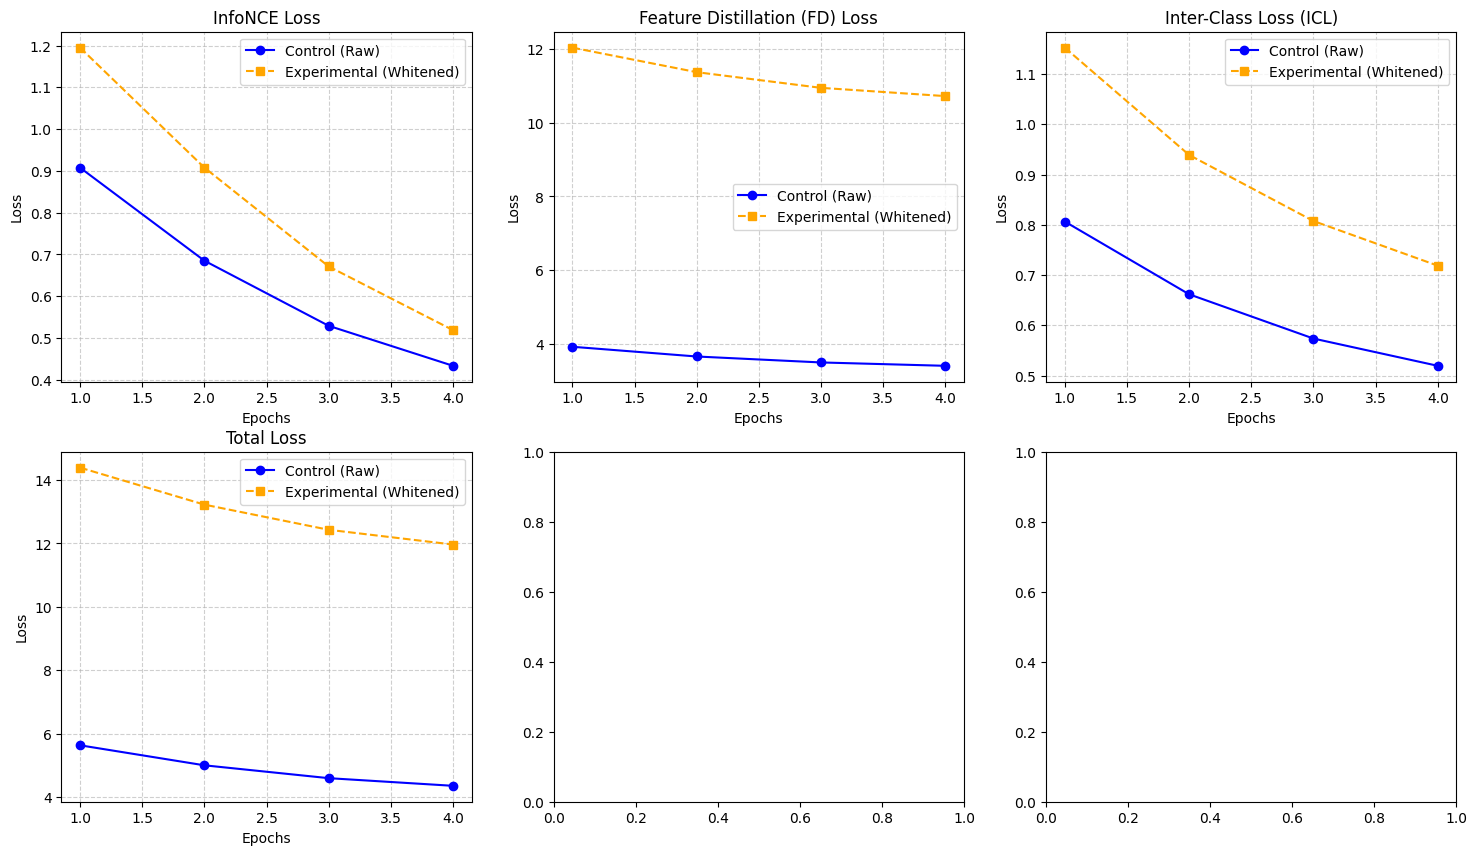

In [44]:
metrics = ['nce', 'fd', 'icl', 'total', 'acc']
titles = {
    'nce': 'InfoNCE Loss',
    'fd': 'Feature Distillation (FD) Loss',
    'icl': 'Inter-Class Loss (ICL)',
    'total': 'Total Loss',
    'acc': 'Zero-Shot Accuracy'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    epochs_range = range(1, epochs + 1)

    ax.plot(epochs_range, history['control'][metric],
            label='Control (Raw)', marker='o', linestyle='-', color='blue')

    ax.plot(epochs_range, history['white'][metric],
            label='Experimental (Whitened)', marker='s', linestyle='--', color='orange')

    ax.set_title(titles[metric])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss' if metric != 'acc' else 'Accuracy')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [40]:
acc_c = evaluate_zsi(student, cifar_loader,text_descriptions,tokenizer_t, device)
acc_w = evaluate_zsi(student_white, cifar_loader,text_descriptions,tokenizer_t, device)

💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...
💬 Encoding Class Descriptions...
📸 Encoding Images & Predicting...


In [ ]:
##EPOCHS 4 and 5 DONE in the training loo[]

In [33]:
print(acc_c,acc_w)##epoch1

0.6044 0.632


In [38]:
print(acc_c,acc_w)##epoch2

0.629 0.6346


In [41]:
print(acc_c,acc_w)##epoch3

0.5676 0.6248


In [34]:
import torch
import torch.nn.functional as F

def evaluate_zsi1(model, loader, text_descriptions, tokenizer, device):
    """
    Zero-Shot Image Classification Evaluation.
    Fixes the 'mode' error by passing dummy inputs to the unified forward().
    """
    model.eval()

    # --- 1. Encode Text Descriptions (Classes) ---
    print("💬 Encoding Class Descriptions...")

    # Tokenize
    text_tokens = tokenizer(text_descriptions).to(device) # [Num_Classes, 77]
    num_classes = len(text_descriptions)

    # Create Dummy Images (Batch size = Num_Classes) to satisfy forward()
    # Assuming standard resolution 256x256.
    # MobileViT/ResNet usually handle any resolution, so this is safe.
    dummy_images = torch.zeros((num_classes, 3, 256, 256), device=device)

    with torch.no_grad():
        # We pass dummy images, but we only care about the text output (2nd return value)
        _, text_embeds, _ = model(dummy_images, text_tokens)

        # Normalize text embeddings
        text_embeds = F.normalize(text_embeds, dim=-1)

    # --- 2. Encode Images & Calculate Accuracy ---
    print("📸 Encoding Images & Predicting...")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.shape[0]

            # Create Dummy Text (Batch size = current batch)
            dummy_text = torch.zeros((batch_size, 77), dtype=torch.long, device=device)

            # We pass dummy text, but we only care about the image output (1st return value)
            image_embeds, _, scale = model(images, dummy_text)

            # Normalize image embeddings
            image_embeds = F.normalize(image_embeds, dim=-1)

            # --- 3. Zero-Shot Prediction ---
            # Cosine similarity: (Batch, 512) @ (Classes, 512).T -> (Batch, Classes)
            logits = (scale * image_embeds @ text_embeds.t())
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

Analysis

🔄 collecting 1000 samples for analysis...
✅ Data Collection Complete. Beginning Analysis...

⏳ Running t-SNE (this might take a moment)...
⏳ Computing Correlation Matrices...


/tmp/ipython-input-1547261685.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


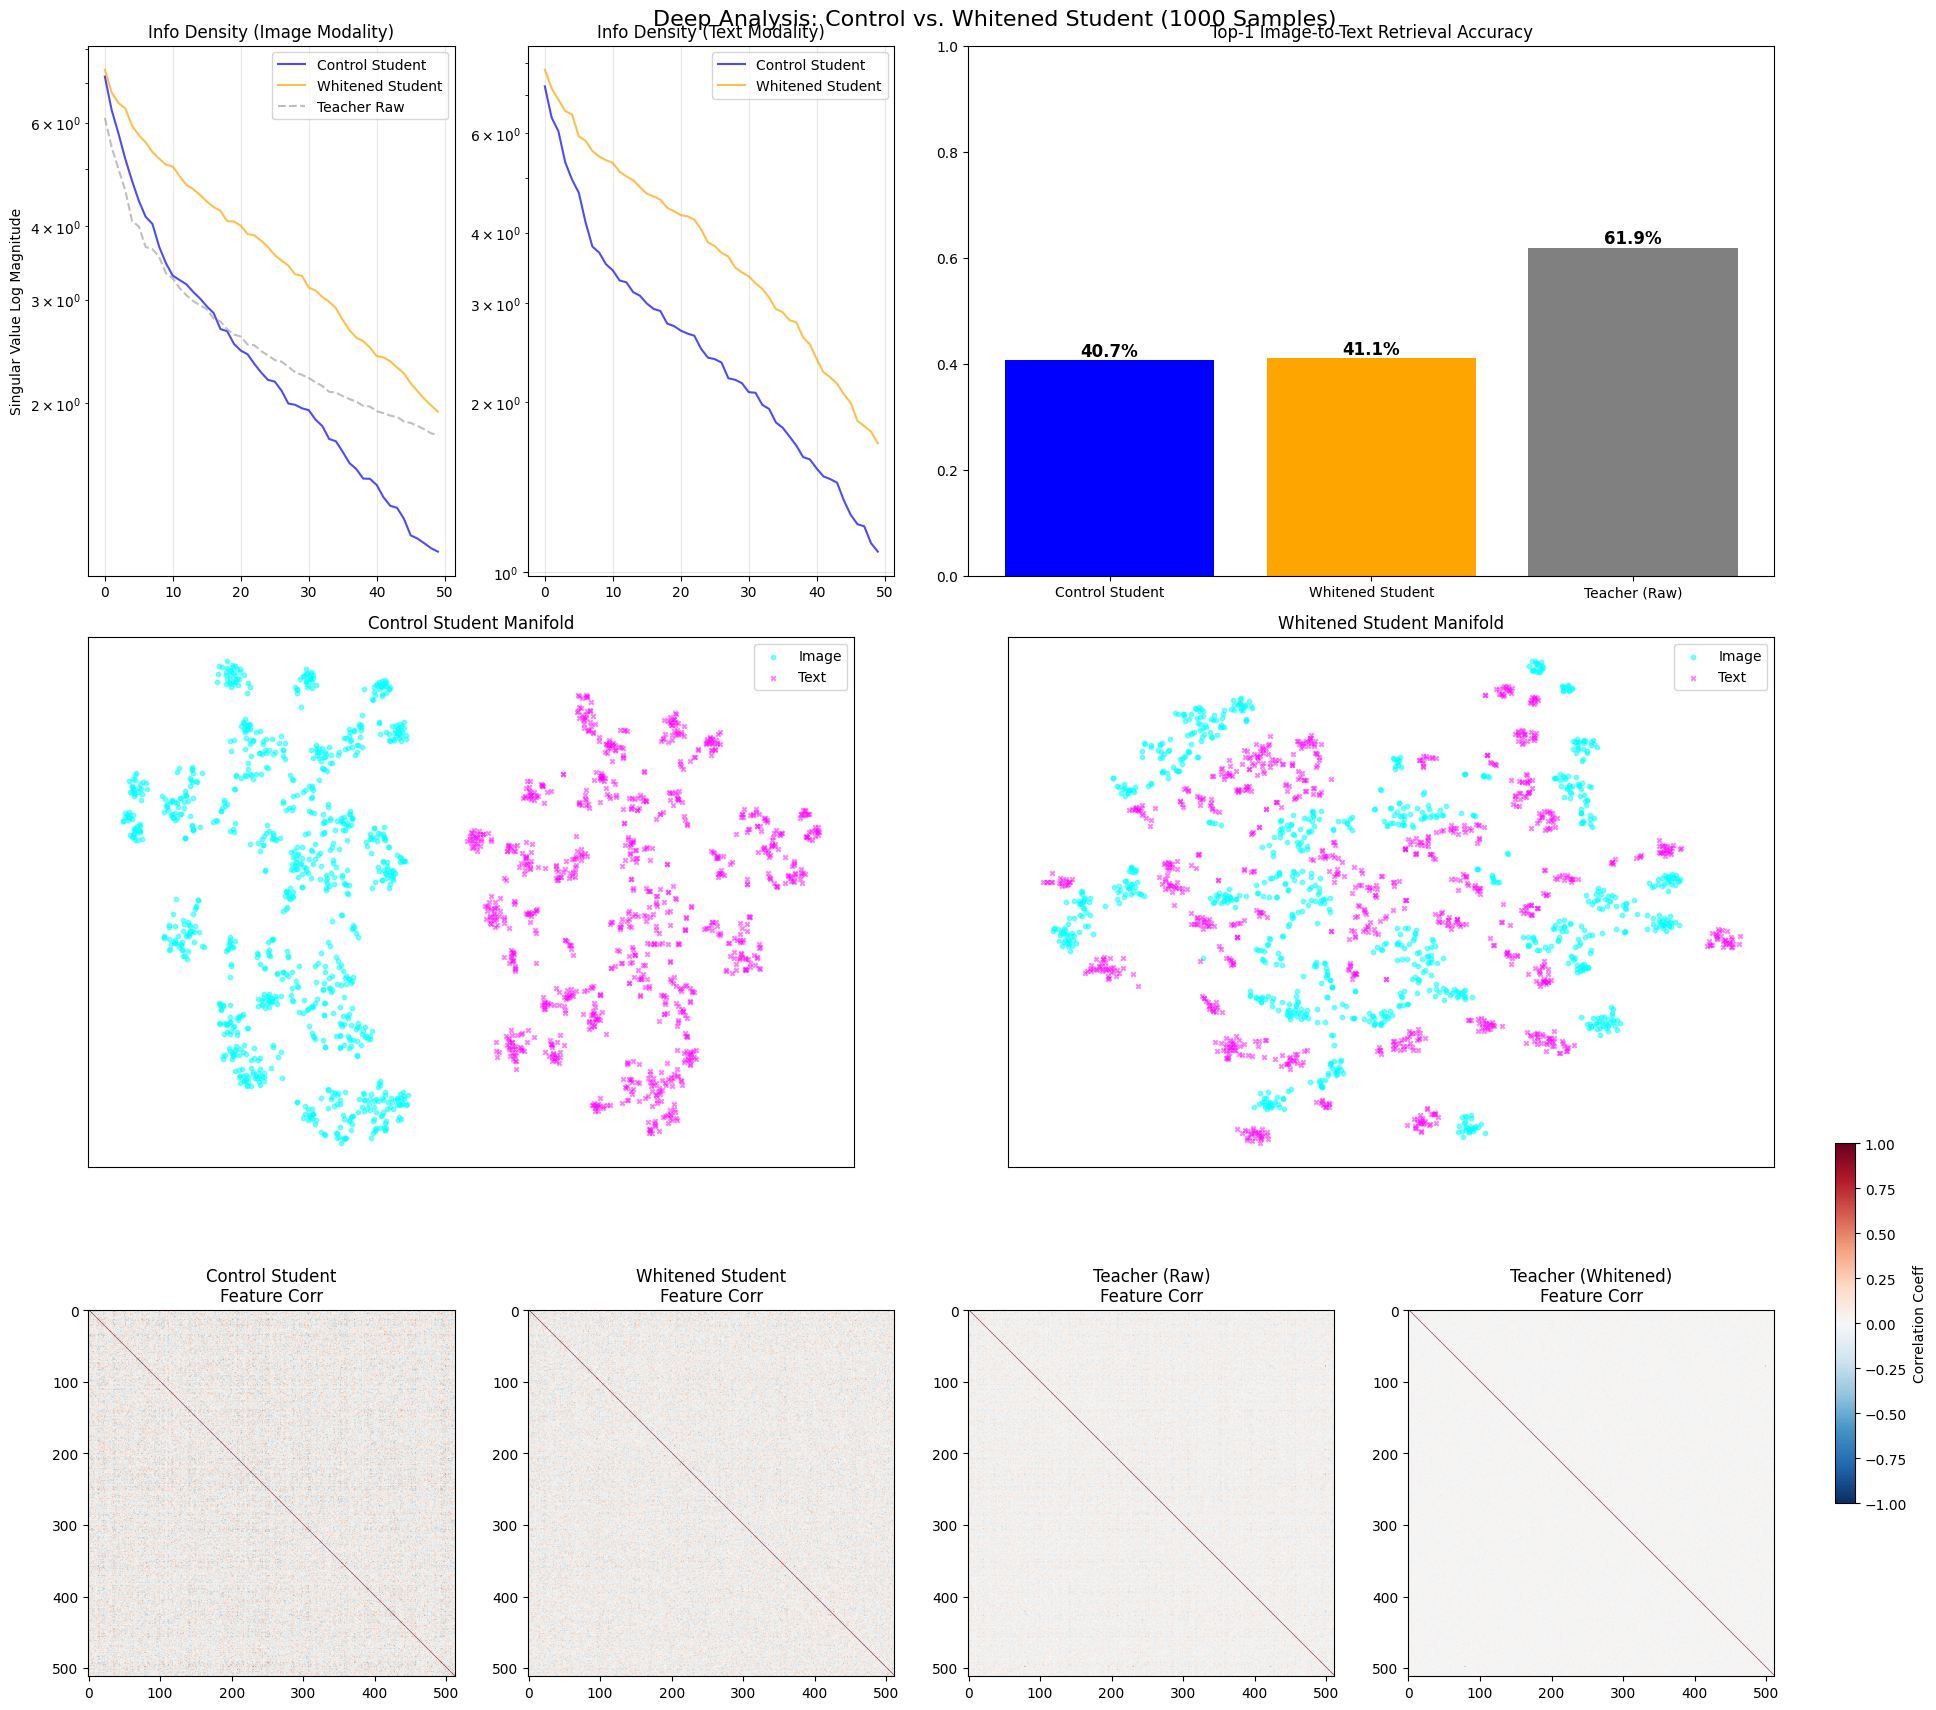

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# --- CONFIGURATION ---
NUM_SAMPLES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure models are in eval mode
student.eval()
student_white.eval()

# Containers for collecting 1k samples
data_store = {
    'control': {'img': [], 'txt': []},
    'white':   {'img': [], 'txt': []},
    'teacher_raw':   {'img': [], 'txt': []},
    'teacher_white': {'img': [], 'txt': []}
}

print(f"🔄 collecting {NUM_SAMPLES} samples for analysis...")

with torch.no_grad():
    collected = 0
    # Use 'student_loader' or 'cifar_loader' depending on what is active
    loader_iter = iter(student_loader)

    while collected < NUM_SAMPLES:
        try:
            batch = next(loader_iter)
        except StopIteration:
            break

        # Unpack batch (Handle variances in loader return signature)
        if len(batch) == 4:
            imgs, tokens, t_v_raw, t_t_raw = batch
        else:
            imgs, tokens, _ = batch # Fallback if no teacher targets provided by loader
            t_v_raw, t_t_raw = None, None # Handle strictly if teacher inference needed inside

        imgs, tokens = imgs.to(device), tokens.to(device)
        t_v_raw, t_t_raw = t_v_raw.to(device), t_t_raw.to(device)

        # 1. Control Student Inference
        sc_v, sc_t, _ = student(imgs, tokens, mode='both')
        # We take the projected (512-dim) features for fair comparison if heads exist
        if hasattr(student, 'v_distill_head'):
            sc_v = student.v_distill_head(sc_v)
            sc_t = student.t_distill_head(sc_t)

        # 2. Whitened Student Inference
        sw_v, sw_t, _ = student_white(imgs, tokens, mode='both')
        if hasattr(student_white, 'v_distill_head'):
            sw_v = student_white.v_distill_head(sw_v)
            sw_t = student_white.t_distill_head(sw_t)

        # 3. Teacher Whitening (Manually apply transform)
        # (t - mu) @ W
        t_v_white = (t_v_raw - mu_img.to(device)) @ W_img.to(device)
        t_t_white = (t_t_raw - mu_txt.to(device)) @ W_txt.to(device)

        # Store Batch
        data_store['control']['img'].append(sc_v.cpu())
        data_store['control']['txt'].append(sc_t.cpu())

        data_store['white']['img'].append(sw_v.cpu())
        data_store['white']['txt'].append(sw_t.cpu())

        data_store['teacher_raw']['img'].append(t_v_raw.cpu())
        data_store['teacher_raw']['txt'].append(t_t_raw.cpu())

        data_store['teacher_white']['img'].append(t_v_white.cpu())
        data_store['teacher_white']['txt'].append(t_t_white.cpu())

        collected += imgs.size(0)

# Concatenate all lists into Tensors/Numpy
for model_key in data_store:
    for modality in ['img', 'txt']:
        tensor_data = torch.cat(data_store[model_key][modality], dim=0)[:NUM_SAMPLES]
        # Normalize for cosine similarity operations
        tensor_data = F.normalize(tensor_data, p=2, dim=-1)
        data_store[model_key][modality] = tensor_data

print("✅ Data Collection Complete. Beginning Analysis...\n")

# ==========================================
# ANALYSIS & PLOTTING
# ==========================================
fig = plt.figure(figsize=(20, 18))
plt.suptitle(f"Deep Analysis: Control vs. Whitened Student ({NUM_SAMPLES} Samples)", fontsize=16)

# Helper for SVD
def get_svd_spectrum(tensor):
    # Center the data
    centered = tensor - tensor.mean(dim=0)
    # SVD
    _, S, _ = torch.linalg.svd(centered)
    return S.cpu().numpy()

# Helper for Retrieval Accuracy
def get_retrieval_acc(img_feats, txt_feats):
    # Similarity: (N, D) @ (D, N) -> (N, N)
    sim_matrix = img_feats @ txt_feats.t()
    # Argmax
    preds = sim_matrix.argmax(dim=1)
    # Ground Truth is diagonal (0, 1, 2...) since data is paired
    targets = torch.arange(len(preds), device=preds.device)
    acc = (preds == targets).float().mean().item()
    return acc

# --- ROW 1: Info Density (SVD Spectrum) ---
ax1 = plt.subplot(3, 4, 1)
ax1.set_title("Info Density (Image Modality)")
ax1.plot(get_svd_spectrum(data_store['control']['img'])[:50], label='Control Student', color='blue', alpha=0.7)
ax1.plot(get_svd_spectrum(data_store['white']['img'])[:50], label='Whitened Student', color='orange', alpha=0.7)
ax1.plot(get_svd_spectrum(data_store['teacher_raw']['img'])[:50], label='Teacher Raw', color='grey', linestyle='--', alpha=0.5)
ax1.set_ylabel("Singular Value Log Magnitude")
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 4, 2)
ax2.set_title("Info Density (Text Modality)")
ax2.plot(get_svd_spectrum(data_store['control']['txt'])[:50], label='Control Student', color='blue', alpha=0.7)
ax2.plot(get_svd_spectrum(data_store['white']['txt'])[:50], label='Whitened Student', color='orange', alpha=0.7)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- ROW 1 (Right): Nearest Neighbor Accuracy ---
acc_control = get_retrieval_acc(data_store['control']['img'], data_store['control']['txt'])
acc_white   = get_retrieval_acc(data_store['white']['img'],   data_store['white']['txt'])
acc_t_raw   = get_retrieval_acc(data_store['teacher_raw']['img'], data_store['teacher_raw']['txt'])

ax3 = plt.subplot(3, 4, (3, 4))
ax3.set_title("Top-1 Image-to-Text Retrieval Accuracy")
bars = ax3.bar(['Control Student', 'Whitened Student', 'Teacher (Raw)'],
               [acc_control, acc_white, acc_t_raw],
               color=['blue', 'orange', 'grey'])
ax3.set_ylim(0, 1.0)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')


# --- ROW 2: t-SNE Maps ---
# We compute t-SNE on concatenated Image+Text to see alignment
print("⏳ Running t-SNE (this might take a moment)...")

def plot_tsne_subplot(ax, img_data, txt_data, title):
    combined = torch.cat([img_data, txt_data], dim=0).numpy()
    # Labels: 0 for Image, 1 for Text
    labels = np.concatenate([np.zeros(len(img_data)), np.ones(len(txt_data))])

    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    embed_2d = tsne.fit_transform(combined)

    # Plot Images
    ax.scatter(embed_2d[labels==0, 0], embed_2d[labels==0, 1],
               c='cyan', label='Image', s=10, alpha=0.5, marker='o')
    # Plot Texts
    ax.scatter(embed_2d[labels==1, 0], embed_2d[labels==1, 1],
               c='magenta', label='Text', s=10, alpha=0.5, marker='x')
    ax.set_title(title)
    ax.legend()
    ax.set_xticks([])
    ax.set_yticks([])

ax4 = plt.subplot(3, 2, 3)
plot_tsne_subplot(ax4, data_store['control']['img'], data_store['control']['txt'], "Control Student Manifold")

ax5 = plt.subplot(3, 2, 4)
plot_tsne_subplot(ax5, data_store['white']['img'], data_store['white']['txt'], "Whitened Student Manifold")


# --- ROW 3: Feature Correlation Matrices ---
# We look at the correlation of the FEATURES (dimensions), not the samples.
# Ideally, whitening leads to a diagonal matrix (uncorrelated features).

def plot_corr_matrix(ax, data_tensor, title):
    # Correlation of features: Transpose so shapes are (Dim, N)
    # data_tensor is (N, Dim)
    corr = np.corrcoef(data_tensor.numpy().T)
    im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title)
    return im

print("⏳ Computing Correlation Matrices...")

ax6 = plt.subplot(3, 4, 9)
plot_corr_matrix(ax6, data_store['control']['img'], "Control Student\nFeature Corr")

ax7 = plt.subplot(3, 4, 10)
plot_corr_matrix(ax7, data_store['white']['img'], "Whitened Student\nFeature Corr")

ax8 = plt.subplot(3, 4, 11)
plot_corr_matrix(ax8, data_store['teacher_raw']['img'], "Teacher (Raw)\nFeature Corr")

ax9 = plt.subplot(3, 4, 12)
im = plot_corr_matrix(ax9, data_store['teacher_white']['img'], "Teacher (Whitened)\nFeature Corr")

# Colorbar for the correlation row
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.2]) # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Correlation Coeff')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

Epoch 1/2: 100%|██████████| 463/463 [09:17<00:00,  1.20s/it, C_tot=0.39, C_icl=0.01, C_fd=0.38, W_tot=1.20, W_icl=0.02, W_fd=1.18]



📊 Epoch 1 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


   Control Accuracy:   60.04%
   Whitened Accuracy:  61.32%
----------------------------------------


Epoch 2/2: 100%|██████████| 463/463 [09:16<00:00,  1.20s/it, C_tot=0.63, C_icl=0.12, C_fd=0.46, W_tot=1.41, W_icl=0.10, W_fd=1.25]



📊 Epoch 2 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


   Control Accuracy:   59.04%
   Whitened Accuracy:  60.37%
----------------------------------------

✅ Dual Training Complete. Generating Plots...


ValueError: x and y must have same first dimension, but have shapes (2,) and (7,)

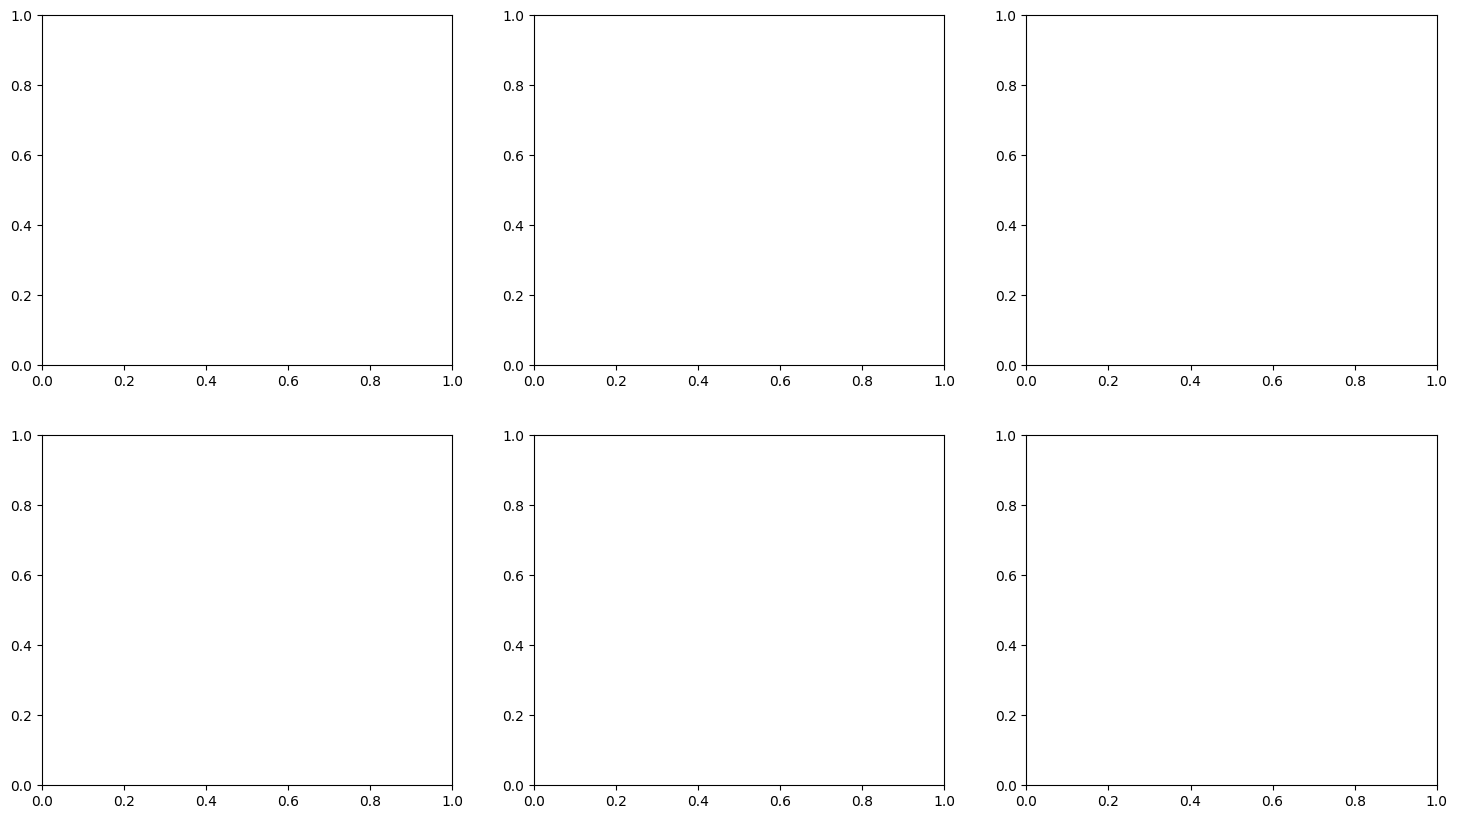

In [28]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 1. Modular Loss Functions (Reusable) ---
def get_infonce_loss(s_v, s_t, logit_scale):
    labels = torch.arange(len(s_v), device=s_v.device)
    s_v = F.normalize(s_v, p=2, dim=-1)
    s_t = F.normalize(s_t, p=2, dim=-1)
    logits_st = logit_scale * s_v @ s_t.t()
    return (F.cross_entropy(logits_st, labels) + F.cross_entropy(logits_st.t(), labels)) / 2

def get_fd_loss(s_v_512, s_t_512, t_v_target, t_t_target, alpha):
    s_v_norm = F.normalize(s_v_512, p=2, dim=-1)
    s_t_norm = F.normalize(s_t_512, p=2, dim=-1)
    return (F.mse_loss(s_v_norm, t_v_target) + F.mse_loss(s_t_norm, t_t_target)) * alpha

def get_icl_loss(s_v_512, s_t_512, t_v_target, t_t_target, logit_scale):
    labels = torch.arange(len(s_v_512), device=s_v_512.device)
    s_v_norm = F.normalize(s_v_512, p=2, dim=-1)
    s_t_norm = F.normalize(s_t_512, p=2, dim=-1)
    logits_sv_tt = logit_scale * s_v_norm @ t_t_target.t()
    logits_st_tv = logit_scale * s_t_norm @ t_v_target.t()
    return (F.cross_entropy(logits_sv_tt, labels) + F.cross_entropy(logits_st_tv, labels)) / 2

# --- 2. Setup Optimizers ---
lr = 0.5e-4
alpha = 200.0
epochs = 2

# Control Model (Standard KD)
# --- 3. The Dual Loop ---
for epoch in range(epochs):
    student.train()
    student_white.train()

    # Initialize running totals for this epoch
    run_c = {'nce': 0.0, 'fd': 0.0, 'icl': 0.0, 'total': 0.0}
    run_w = {'nce': 0.0, 'fd': 0.0, 'icl': 0.0, 'total': 0.0}

    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{epochs}")
    num_batches = len(student_loader)

    for imgs, tokens, t_v_raw, t_t_raw in pbar:
        # Move data to GPU once
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_v_raw, t_t_raw = t_v_raw.to(device), t_t_raw.to(device)

        # --- PREPARE TARGETS ---
        with torch.no_grad():
            # Target A: Control (Raw -> Normalized)
            t_v_control = F.normalize(t_v_raw, p=2, dim=-1)
            t_t_control = F.normalize(t_t_raw, p=2, dim=-1)

            # Target B: White (Raw -> Whiten -> Normalized)
            t_v_white = F.normalize((t_v_raw - mu_img) @ W_img, p=2, dim=-1)
            t_t_white = F.normalize((t_t_raw - mu_txt) @ W_txt, p=2, dim=-1)

        # ==========================================
        # 1. TRAIN CONTROL MODEL (Student)
        # ==========================================
        opt_control.zero_grad()

        sc_v_384, sc_t_384, l_scale_c = student(imgs, tokens, mode='both')
        sc_v_512 = student.v_distill_head(sc_v_384)
        sc_t_512 = student.t_distill_head(sc_t_384)

        lc_nce = get_infonce_loss(sc_v_384, sc_t_384, l_scale_c)
        lc_fd  = get_fd_loss(sc_v_512, sc_t_512, t_v_control, t_t_control, alpha)
        lc_icl = get_icl_loss(sc_v_512, sc_t_512, t_v_control, t_t_control, l_scale_c)

        loss_control = lc_nce + lc_fd + lc_icl
        loss_control.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        opt_control.step()

        # Accumulate Control Losses
        run_c['nce']   += lc_nce.item()
        run_c['fd']    += lc_fd.item()
        run_c['icl']   += lc_icl.item()
        run_c['total'] += loss_control.item()

        # ==========================================
        # 2. TRAIN EXPERIMENTAL MODEL (Student White)
        # ==========================================
        opt_white.zero_grad()

        sw_v_384, sw_t_384, l_scale_w = student_white(imgs, tokens, mode='both')
        sw_v_512 = student_white.v_distill_head(sw_v_384)
        sw_t_512 = student_white.t_distill_head(sw_t_384)

        lw_nce = get_infonce_loss(sw_v_384, sw_t_384, l_scale_w)
        lw_fd  = get_fd_loss(sw_v_512, sw_t_512, t_v_white, t_t_white, alpha)
        lw_icl = get_icl_loss(sw_v_512, sw_t_512, t_v_white, t_t_white, l_scale_w)

        loss_white = lw_nce + lw_fd + lw_icl
        loss_white.backward()
        torch.nn.utils.clip_grad_norm_(student_white.parameters(), 1.0)
        opt_white.step()

        # Accumulate White Losses
        run_w['nce']   += lw_nce.item()
        run_w['fd']    += lw_fd.item()
        run_w['icl']   += lw_icl.item()
        run_w['total'] += loss_white.item()

        # Update Progress Bar (Current Batch values)
        pbar.set_postfix({
            'C_tot': f"{loss_control.item():.2f}",
            'C_icl': f"{lc_icl.item():.2f}",
            'C_fd': f"{lc_fd.item():.2f}",
            'W_tot': f"{loss_white.item():.2f}",
            'W_icl': f"{lw_icl.item():.2f}",
            'W_fd': f"{lw_fd.item():.2f}"
        })

    sch_control.step()
    sch_white.step()

    # --- SAVE EPOCH AVERAGES ---
    # Average each component by number of batches and store
    for k in ['nce', 'fd', 'icl', 'total']:
        history['control'][k].append(run_c[k] / num_batches)
        history['white'][k].append(run_w[k] / num_batches)

    # --- EVALUATION ---
    print(f"\n📊 Epoch {epoch+1} Results:")

    # Eval Control
    student.eval()
    acc_c = evaluate_zsi(student, cifar_loader, text_descriptions, tokenizer_t, device)
    history['control']['acc'].append(acc_c)

    # Eval White
    student_white.eval()
    acc_w = evaluate_zsi(student_white, cifar_loader, text_descriptions, tokenizer_t, device)
    history['white']['acc'].append(acc_w)

    print(f"   Control Accuracy:   {acc_c*100:.2f}%")
    print(f"   Whitened Accuracy:  {acc_w*100:.2f}%")
    print("-" * 40)




✅ Dual Training Complete. Generating Plots...


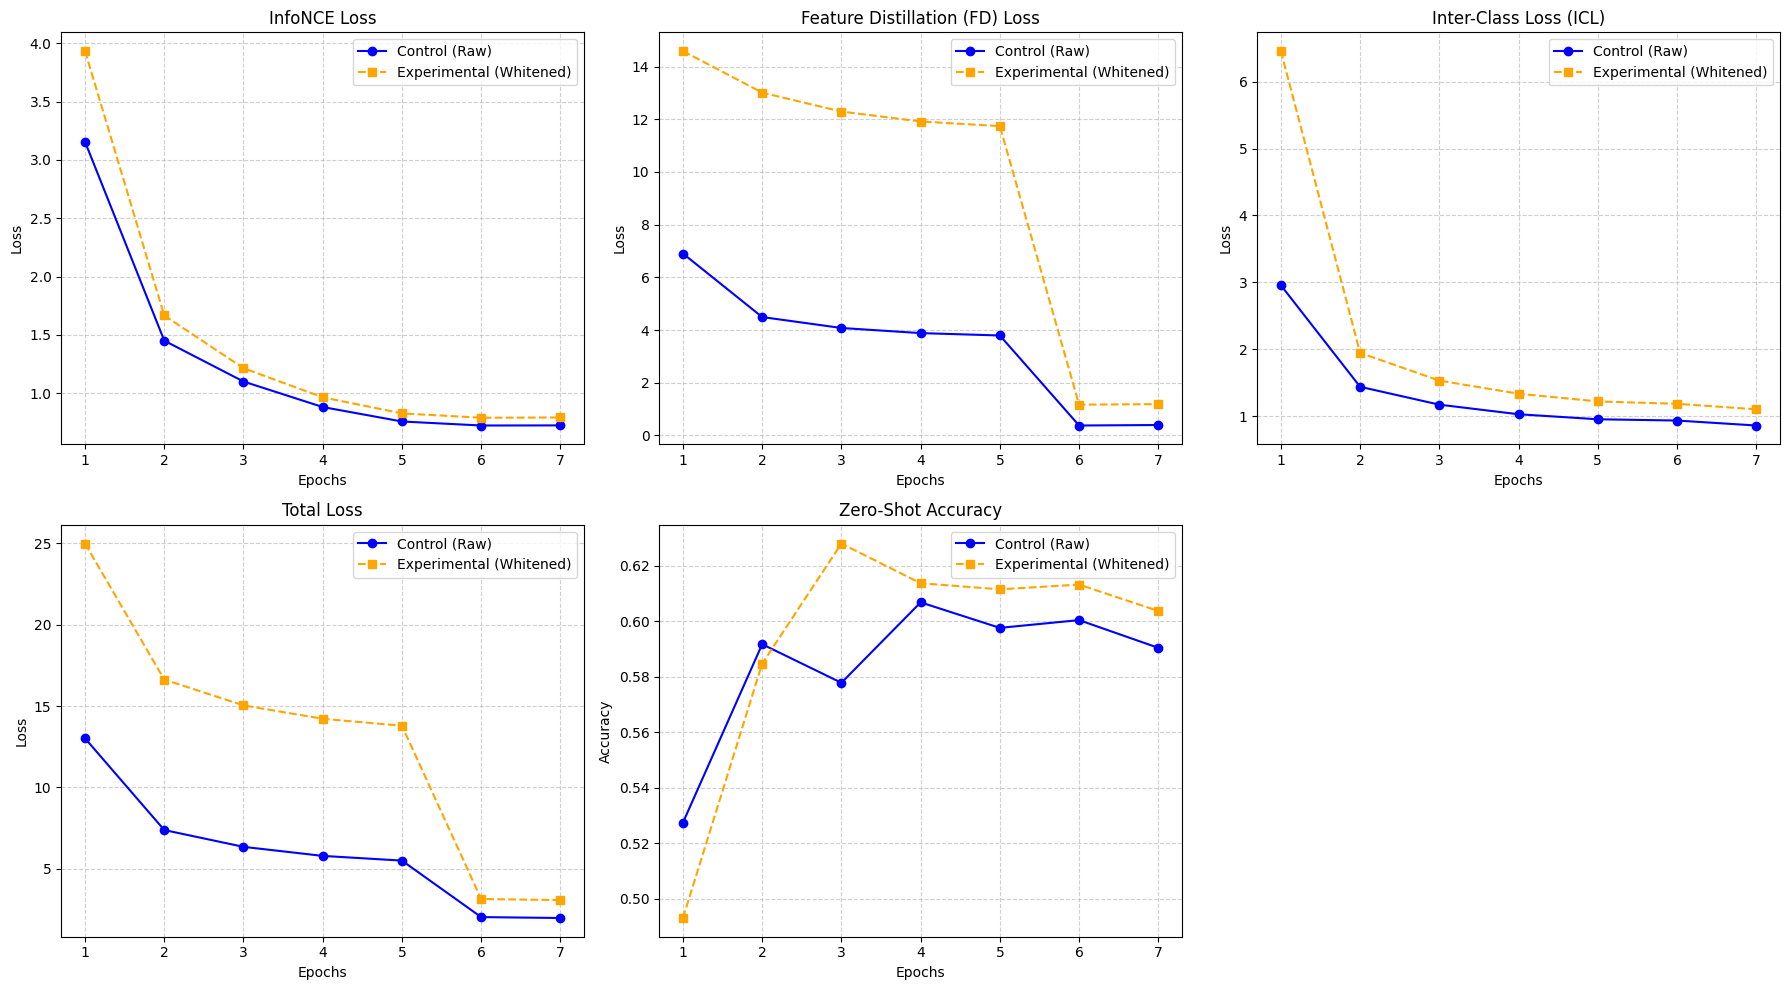

In [30]:
print("\n✅ Dual Training Complete. Generating Plots...")

# --- 4. Plotting Results ---
metrics = ['nce', 'fd', 'icl', 'total', 'acc']
titles = {
    'nce': 'InfoNCE Loss',
    'fd': 'Feature Distillation (FD) Loss',
    'icl': 'Inter-Class Loss (ICL)',
    'total': 'Total Loss',
    'acc': 'Zero-Shot Accuracy'
}

# Create a figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Flatten to 1D array for easy iteration

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    ax = axes[i]
    epochs_range = range(1, 7 + 1)

    # Plot Control line
    ax.plot(epochs_range, history['control'][metric],
            label='Control (Raw)', marker='o', linestyle='-', color='blue')

    # Plot White line
    ax.plot(epochs_range, history['white'][metric],
            label='Experimental (Whitened)', marker='s', linestyle='--', color='orange')

    ax.set_title(titles[metric])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss' if metric != 'acc' else 'Accuracy')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# Remove the empty 6th subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

🔄 collecting 1000 samples for analysis...
✅ Data Collection Complete. Beginning Analysis...

⏳ Running t-SNE (this might take a moment)...
⏳ Computing Correlation Matrices...


/tmp/ipython-input-1547261685.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


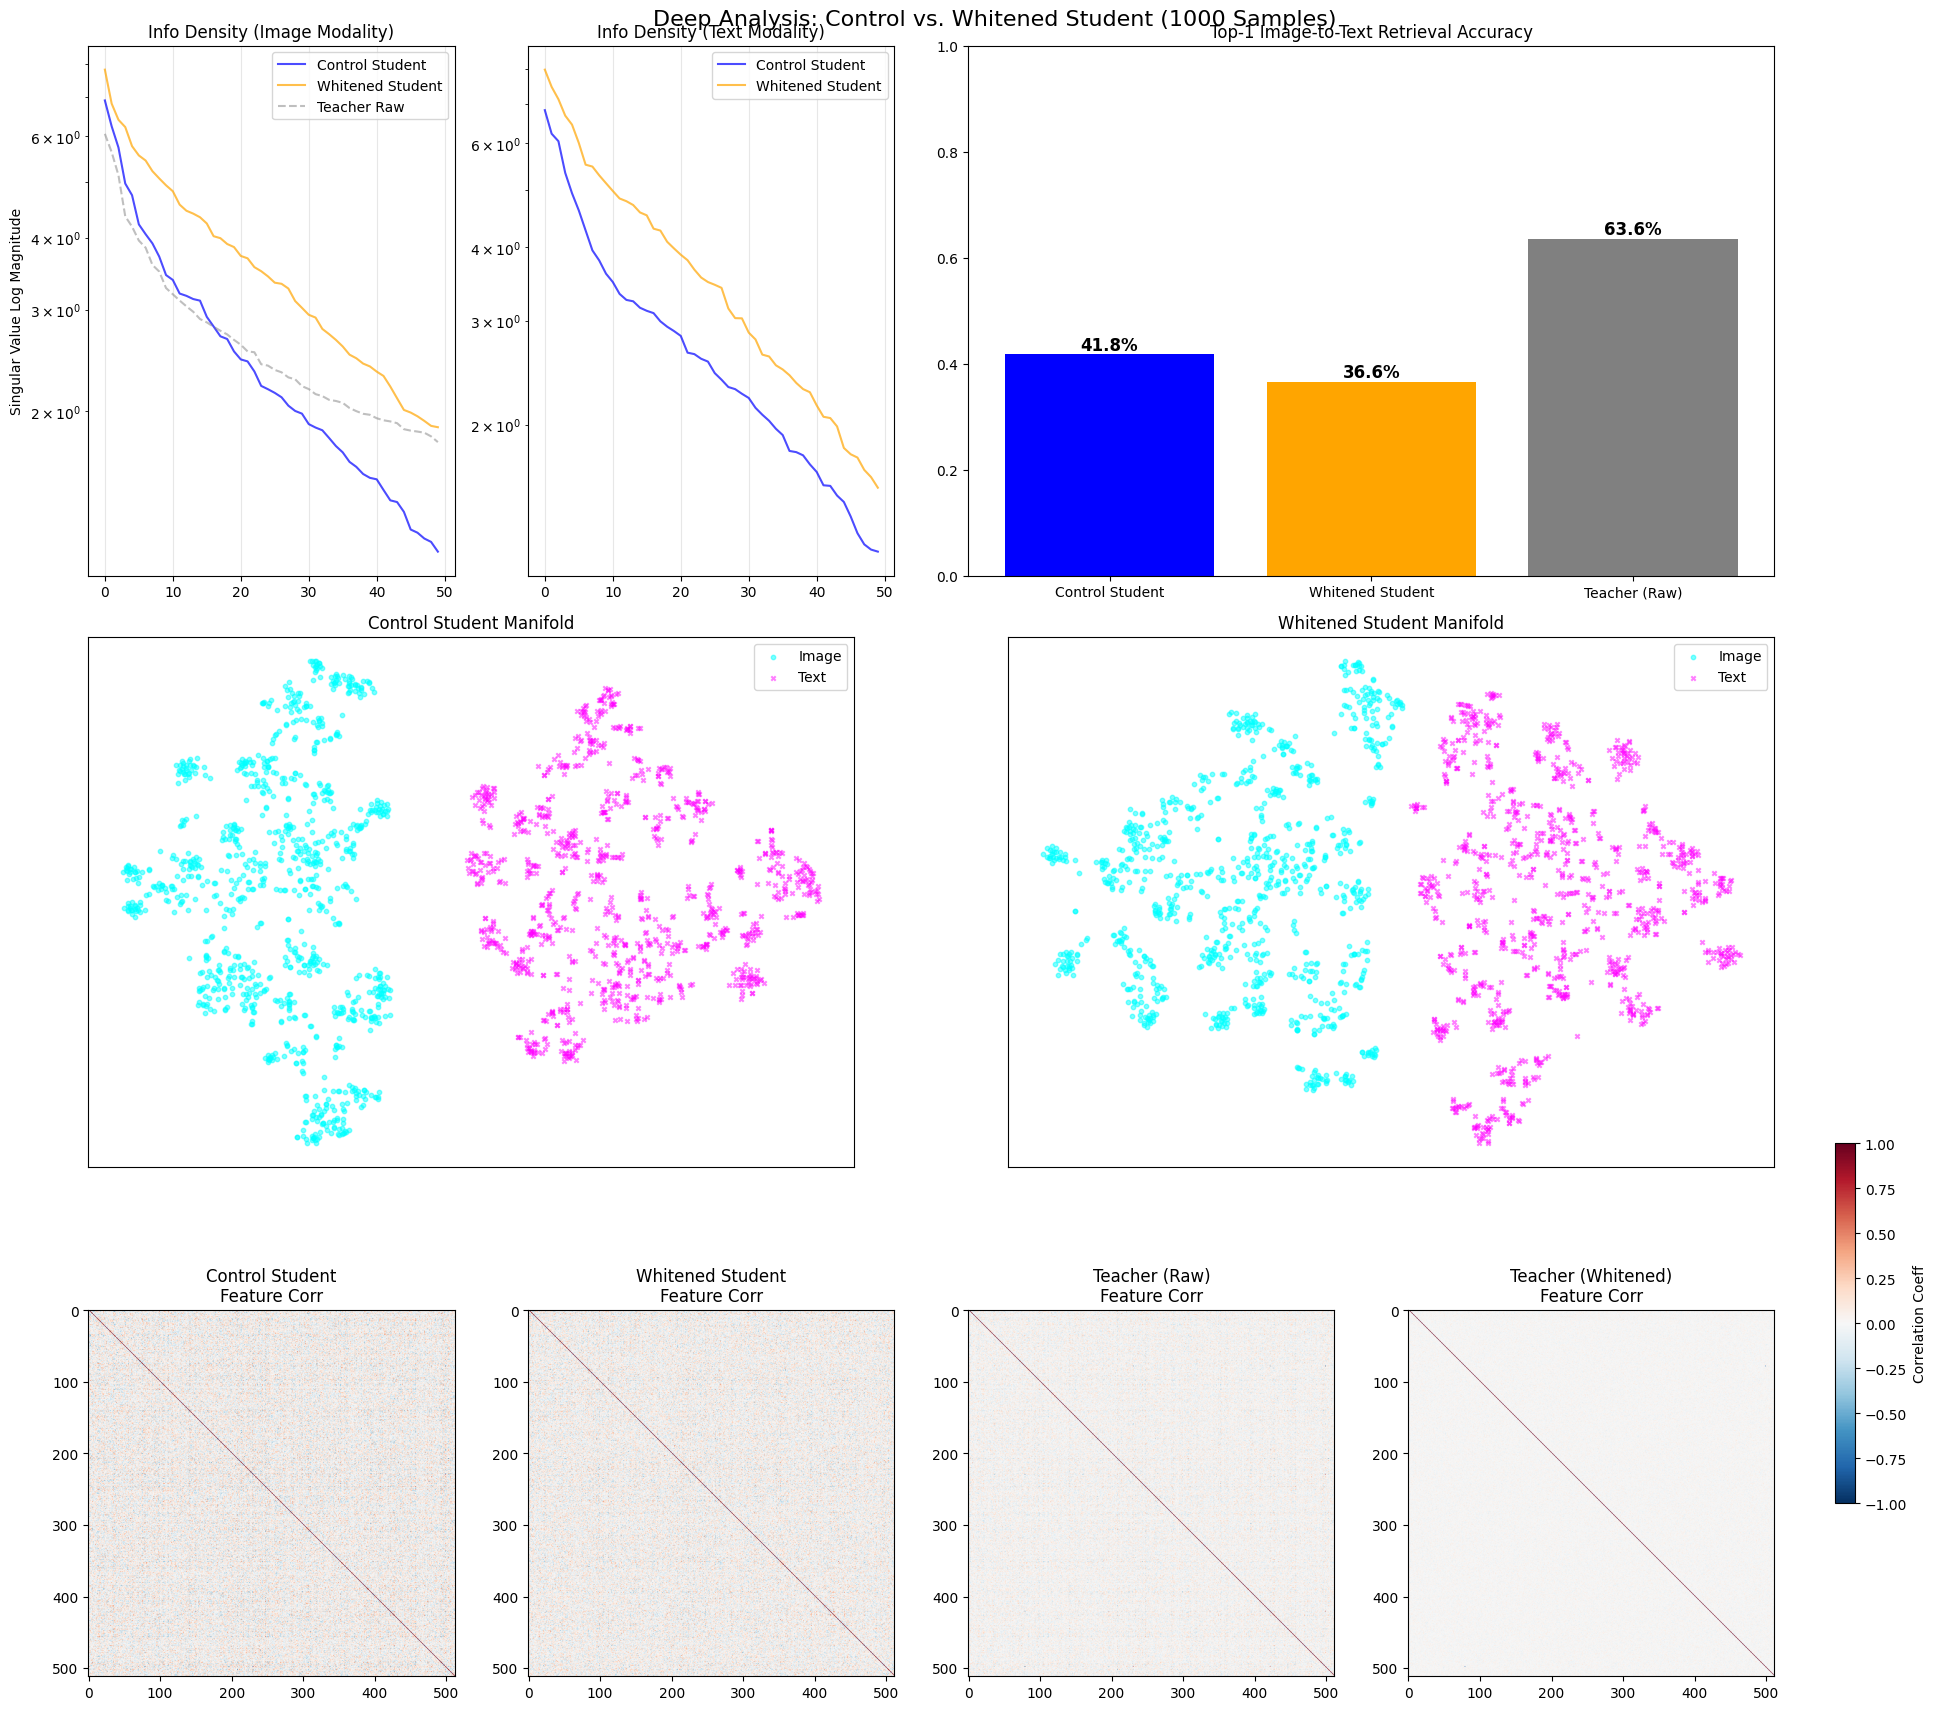

In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# --- CONFIGURATION ---
NUM_SAMPLES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure models are in eval mode
student.eval()
student_white.eval()

# Containers for collecting 1k samples
data_store = {
    'control': {'img': [], 'txt': []},
    'white':   {'img': [], 'txt': []},
    'teacher_raw':   {'img': [], 'txt': []},
    'teacher_white': {'img': [], 'txt': []}
}

print(f"🔄 collecting {NUM_SAMPLES} samples for analysis...")

with torch.no_grad():
    collected = 0
    # Use 'student_loader' or 'cifar_loader' depending on what is active
    loader_iter = iter(student_loader)

    while collected < NUM_SAMPLES:
        try:
            batch = next(loader_iter)
        except StopIteration:
            break

        # Unpack batch (Handle variances in loader return signature)
        if len(batch) == 4:
            imgs, tokens, t_v_raw, t_t_raw = batch
        else:
            imgs, tokens, _ = batch # Fallback if no teacher targets provided by loader
            t_v_raw, t_t_raw = None, None # Handle strictly if teacher inference needed inside

        imgs, tokens = imgs.to(device), tokens.to(device)
        t_v_raw, t_t_raw = t_v_raw.to(device), t_t_raw.to(device)

        # 1. Control Student Inference
        sc_v, sc_t, _ = student(imgs, tokens, mode='both')
        # We take the projected (512-dim) features for fair comparison if heads exist
        if hasattr(student, 'v_distill_head'):
            sc_v = student.v_distill_head(sc_v)
            sc_t = student.t_distill_head(sc_t)

        # 2. Whitened Student Inference
        sw_v, sw_t, _ = student_white(imgs, tokens, mode='both')
        if hasattr(student_white, 'v_distill_head'):
            sw_v = student_white.v_distill_head(sw_v)
            sw_t = student_white.t_distill_head(sw_t)

        # 3. Teacher Whitening (Manually apply transform)
        # (t - mu) @ W
        t_v_white = (t_v_raw - mu_img.to(device)) @ W_img.to(device)
        t_t_white = (t_t_raw - mu_txt.to(device)) @ W_txt.to(device)

        # Store Batch
        data_store['control']['img'].append(sc_v.cpu())
        data_store['control']['txt'].append(sc_t.cpu())

        data_store['white']['img'].append(sw_v.cpu())
        data_store['white']['txt'].append(sw_t.cpu())

        data_store['teacher_raw']['img'].append(t_v_raw.cpu())
        data_store['teacher_raw']['txt'].append(t_t_raw.cpu())

        data_store['teacher_white']['img'].append(t_v_white.cpu())
        data_store['teacher_white']['txt'].append(t_t_white.cpu())

        collected += imgs.size(0)

# Concatenate all lists into Tensors/Numpy
for model_key in data_store:
    for modality in ['img', 'txt']:
        tensor_data = torch.cat(data_store[model_key][modality], dim=0)[:NUM_SAMPLES]
        # Normalize for cosine similarity operations
        tensor_data = F.normalize(tensor_data, p=2, dim=-1)
        data_store[model_key][modality] = tensor_data

print("✅ Data Collection Complete. Beginning Analysis...\n")

# ==========================================
# ANALYSIS & PLOTTING
# ==========================================
fig = plt.figure(figsize=(20, 18))
plt.suptitle(f"Deep Analysis: Control vs. Whitened Student ({NUM_SAMPLES} Samples)", fontsize=16)

# Helper for SVD
def get_svd_spectrum(tensor):
    # Center the data
    centered = tensor - tensor.mean(dim=0)
    # SVD
    _, S, _ = torch.linalg.svd(centered)
    return S.cpu().numpy()

# Helper for Retrieval Accuracy
def get_retrieval_acc(img_feats, txt_feats):
    # Similarity: (N, D) @ (D, N) -> (N, N)
    sim_matrix = img_feats @ txt_feats.t()
    # Argmax
    preds = sim_matrix.argmax(dim=1)
    # Ground Truth is diagonal (0, 1, 2...) since data is paired
    targets = torch.arange(len(preds), device=preds.device)
    acc = (preds == targets).float().mean().item()
    return acc

# --- ROW 1: Info Density (SVD Spectrum) ---
ax1 = plt.subplot(3, 4, 1)
ax1.set_title("Info Density (Image Modality)")
ax1.plot(get_svd_spectrum(data_store['control']['img'])[:50], label='Control Student', color='blue', alpha=0.7)
ax1.plot(get_svd_spectrum(data_store['white']['img'])[:50], label='Whitened Student', color='orange', alpha=0.7)
ax1.plot(get_svd_spectrum(data_store['teacher_raw']['img'])[:50], label='Teacher Raw', color='grey', linestyle='--', alpha=0.5)
ax1.set_ylabel("Singular Value Log Magnitude")
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 4, 2)
ax2.set_title("Info Density (Text Modality)")
ax2.plot(get_svd_spectrum(data_store['control']['txt'])[:50], label='Control Student', color='blue', alpha=0.7)
ax2.plot(get_svd_spectrum(data_store['white']['txt'])[:50], label='Whitened Student', color='orange', alpha=0.7)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- ROW 1 (Right): Nearest Neighbor Accuracy ---
acc_control = get_retrieval_acc(data_store['control']['img'], data_store['control']['txt'])
acc_white   = get_retrieval_acc(data_store['white']['img'],   data_store['white']['txt'])
acc_t_raw   = get_retrieval_acc(data_store['teacher_raw']['img'], data_store['teacher_raw']['txt'])

ax3 = plt.subplot(3, 4, (3, 4))
ax3.set_title("Top-1 Image-to-Text Retrieval Accuracy")
bars = ax3.bar(['Control Student', 'Whitened Student', 'Teacher (Raw)'],
               [acc_control, acc_white, acc_t_raw],
               color=['blue', 'orange', 'grey'])
ax3.set_ylim(0, 1.0)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')


# --- ROW 2: t-SNE Maps ---
# We compute t-SNE on concatenated Image+Text to see alignment
print("⏳ Running t-SNE (this might take a moment)...")

def plot_tsne_subplot(ax, img_data, txt_data, title):
    combined = torch.cat([img_data, txt_data], dim=0).numpy()
    # Labels: 0 for Image, 1 for Text
    labels = np.concatenate([np.zeros(len(img_data)), np.ones(len(txt_data))])

    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    embed_2d = tsne.fit_transform(combined)

    # Plot Images
    ax.scatter(embed_2d[labels==0, 0], embed_2d[labels==0, 1],
               c='cyan', label='Image', s=10, alpha=0.5, marker='o')
    # Plot Texts
    ax.scatter(embed_2d[labels==1, 0], embed_2d[labels==1, 1],
               c='magenta', label='Text', s=10, alpha=0.5, marker='x')
    ax.set_title(title)
    ax.legend()
    ax.set_xticks([])
    ax.set_yticks([])

ax4 = plt.subplot(3, 2, 3)
plot_tsne_subplot(ax4, data_store['control']['img'], data_store['control']['txt'], "Control Student Manifold")

ax5 = plt.subplot(3, 2, 4)
plot_tsne_subplot(ax5, data_store['white']['img'], data_store['white']['txt'], "Whitened Student Manifold")


# --- ROW 3: Feature Correlation Matrices ---
# We look at the correlation of the FEATURES (dimensions), not the samples.
# Ideally, whitening leads to a diagonal matrix (uncorrelated features).

def plot_corr_matrix(ax, data_tensor, title):
    # Correlation of features: Transpose so shapes are (Dim, N)
    # data_tensor is (N, Dim)
    corr = np.corrcoef(data_tensor.numpy().T)
    im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title)
    return im

print("⏳ Computing Correlation Matrices...")

ax6 = plt.subplot(3, 4, 9)
plot_corr_matrix(ax6, data_store['control']['img'], "Control Student\nFeature Corr")

ax7 = plt.subplot(3, 4, 10)
plot_corr_matrix(ax7, data_store['white']['img'], "Whitened Student\nFeature Corr")

ax8 = plt.subplot(3, 4, 11)
plot_corr_matrix(ax8, data_store['teacher_raw']['img'], "Teacher (Raw)\nFeature Corr")

ax9 = plt.subplot(3, 4, 12)
im = plot_corr_matrix(ax9, data_store['teacher_white']['img'], "Teacher (Whitened)\nFeature Corr")

# Colorbar for the correlation row
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.2]) # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Correlation Coeff')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

📊 Visualizing WHITENED Student (Experimental)...
🔍 Analyzing Geometry with Separate Modality Whitening...
   Fitting t-SNE on 2718 samples...


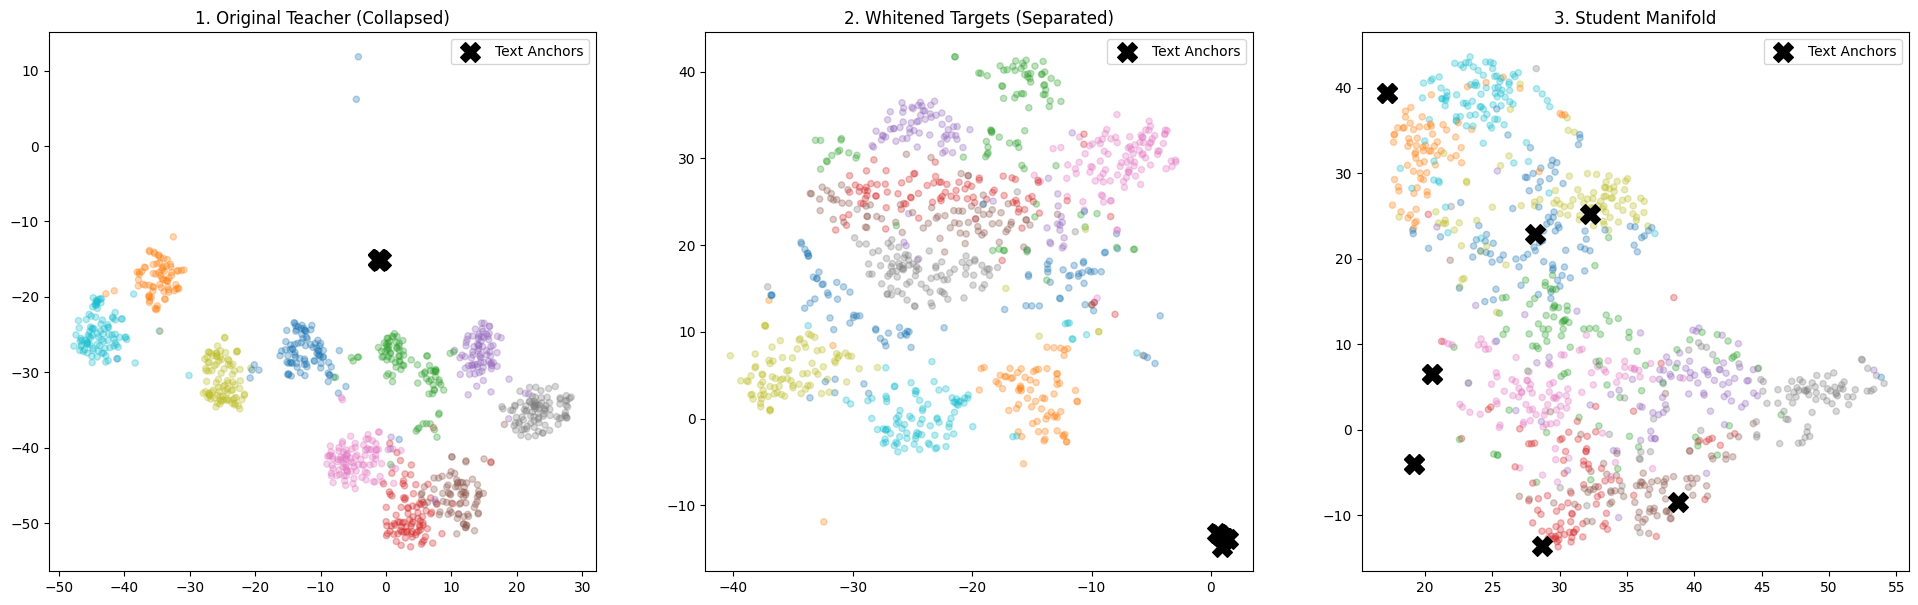


📊 Visualizing RAW Student (Control)...
🔍 Analyzing Geometry with Separate Modality Whitening...
   Fitting t-SNE on 2718 samples...


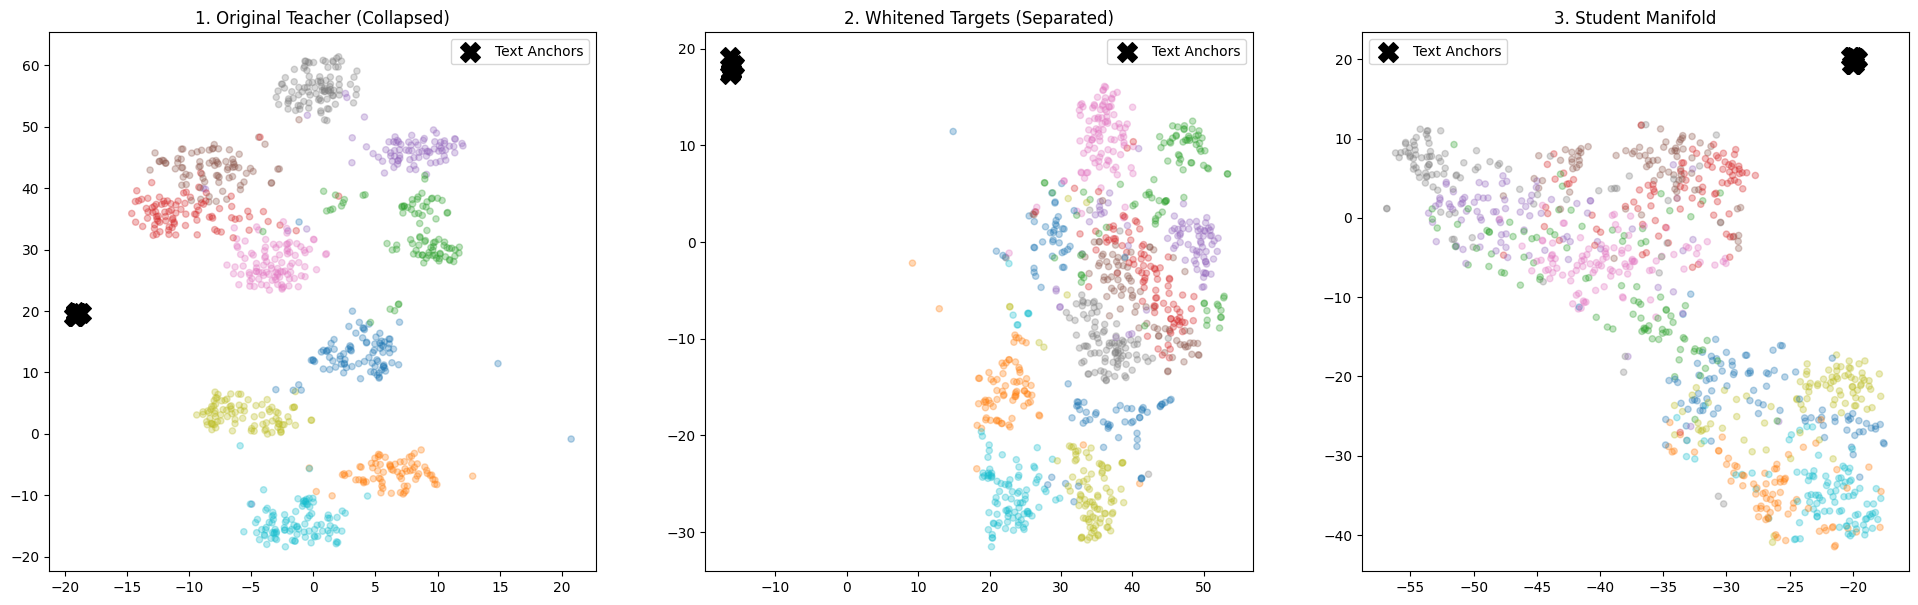

In [41]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

def analyze_full_geometry(student, teacher, loader, text_prompts, tokenizer, mu_img, W_img, mu_txt, W_txt, device):
    student.eval()
    teacher.eval()

    print("🔍 Analyzing Geometry with Separate Modality Whitening...")

    # 1. Get Text Embeddings (Classes 0-9)
    with torch.no_grad():
        # A. Original Teacher Text (Raw)
        t_tokens = tokenizer(text_prompts).to(device)
        t_t_raw = teacher.encode_text(t_tokens)
        t_t_orig = t_t_raw / t_t_raw.norm(dim=-1, keepdim=True) # Normalized for Plot 1

        # B. Whitened Teacher Text Target (Apply Text Stats)
        # Transform Raw -> Whiten -> Normalize
        t_t_white = (t_t_raw - mu_txt) @ W_txt
        t_t_white = t_t_white / t_t_white.norm(dim=-1, keepdim=True) # Normalized for Plot 2

        # C. Student Text (384 -> 512)
        # Note: If student has mode='text_only', use it. Otherwise standard forward.
        try:
            _, s_t_384, _ = student(texts=t_tokens, mode='text_only')
        except:
            _, s_t_384, _ = student(images=torch.randn(10, 3, 224, 224).to(device), texts=t_tokens)

        s_t_512 = student.t_distill_head(s_t_384)
        s_t_512 = s_t_512 / s_t_512.norm(dim=-1, keepdim=True)

    # 2. Get Image Embeddings (Sample batch)
    all_v_s, all_v_t, all_v_t_w, all_labels = [], [], [], []

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(loader):
            imgs = imgs.to(device)

            # A. Student Vision (384 -> 512)
            try:
                s_v_384, _, _ = student(images=imgs, mode='image_only')
            except:
                s_v_384, _, _ = student(images=imgs, texts=t_tokens) # Dummy text

            s_v_512 = student.v_distill_head(s_v_384)
            s_v_512 = s_v_512 / s_v_512.norm(dim=-1, keepdim=True)

            # B. Teacher Vision (Raw)
            t_v_raw = teacher.encode_image(imgs)
            t_v_orig = t_v_raw / t_v_raw.norm(dim=-1, keepdim=True) # Plot 1

            # C. Whitened Teacher Vision Target (Apply Image Stats)
            t_v_white = (t_v_raw - mu_img) @ W_img
            t_v_white = t_v_white / t_v_white.norm(dim=-1, keepdim=True) # Plot 2

            all_v_s.append(s_v_512.cpu().numpy())
            all_v_t.append(t_v_orig.cpu().numpy())
            all_v_t_w.append(t_v_white.cpu().numpy())
            all_labels.append(labels.numpy())

            if i > 5: break # Keep it fast (approx 6 batches)

    # 3. Concatenate for single t-SNE fit
    vs_s = np.concatenate(all_v_s)
    vs_t = np.concatenate(all_v_t)
    vs_tw = np.concatenate(all_v_t_w)
    labels = np.concatenate(all_labels)

    # Combine: [Student Img, Teacher Img, White Teacher Img, S-Text, T-Text, White T-Text]
    combined = np.concatenate([
        vs_s, vs_t, vs_tw,
        s_t_512.cpu().numpy(),
        t_t_orig.cpu().numpy(),
        t_t_white.cpu().numpy()
    ])

    print(f"   Fitting t-SNE on {combined.shape[0]} samples...")
    tsne = TSNE(n_components=2, perplexity=30, metric='cosine', init='pca', random_state=42)
    embeds_2d = tsne.fit_transform(combined)

    # Split back
    n = len(vs_s)
    s_img_2d = embeds_2d[0:n]
    t_img_2d = embeds_2d[n:2*n]
    tw_img_2d = embeds_2d[2*n:3*n]

    # Text indices (last 30 items: 10 student, 10 teacher, 10 white teacher)
    num_classes = len(text_prompts)
    s_txt_2d  = embeds_2d[-3*num_classes : -2*num_classes]
    t_txt_2d  = embeds_2d[-2*num_classes : -num_classes]
    tw_txt_2d = embeds_2d[-num_classes:]

    # 4. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    titles = ["1. Original Teacher (Collapsed)", "2. Whitened Targets (Separated)", "3. Student Manifold"]

    # Plot 1: Original Teacher (The baseline problem)
    axes[0].scatter(t_img_2d[:, 0], t_img_2d[:, 1], c=labels, cmap='tab10', alpha=0.3, s=20)
    axes[0].scatter(t_txt_2d[:, 0], t_txt_2d[:, 1], c='black', marker='X', s=200, label='Text Anchors')
    axes[0].set_title(titles[0])

    # Plot 2: Whitened Targets (The "Geometric Unlock")
    axes[1].scatter(tw_img_2d[:, 0], tw_img_2d[:, 1], c=labels, cmap='tab10', alpha=0.3, s=20)
    axes[1].scatter(tw_txt_2d[:, 0], tw_txt_2d[:, 1], c='black', marker='X', s=200, label='Text Anchors')
    axes[1].set_title(titles[1])

    # Plot 3: Student (What it actually learned)
    axes[2].scatter(s_img_2d[:, 0], s_img_2d[:, 1], c=labels, cmap='tab10', alpha=0.3, s=20)
    axes[2].scatter(s_txt_2d[:, 0], s_txt_2d[:, 1], c='black', marker='X', s=200, label='Text Anchors')
    axes[2].set_title(titles[2])

    for ax in axes: ax.legend()
    plt.show()

# --- EXECUTION ---

print("📊 Visualizing WHITENED Student (Experimental)...")
analyze_full_geometry(student_white, teacher, cifar_loader, text_descriptions, tokenizer_t,
                      mu_img, W_img, mu_txt, W_txt, device)

print("\n📊 Visualizing RAW Student (Control)...")
# Note: We still pass the separate stats to visualize Plot 2 (the target) correctly for comparison
analyze_full_geometry(student, teacher, cifar_loader, text_descriptions, tokenizer_t,
                      mu_img, W_img, mu_txt, W_txt, device)

In [34]:
print(mu_txt)

tensor([-3.9545e-01,  1.4252e-02,  1.1593e-01,  3.3038e-01, -6.6351e-02,
         3.6544e-02, -1.3141e-01, -4.4653e-02, -1.4672e-01, -1.4186e-01,
        -1.0291e-03,  2.6998e-02, -4.5108e-02, -1.0741e-01, -1.6860e-02,
        -3.3465e-02,  8.6025e-03,  2.3982e-01, -1.8512e-02, -3.7837e-02,
        -1.6682e-01,  7.6400e-02,  8.0476e-02,  2.8412e-01,  5.9280e-02,
        -5.7156e-02, -3.4258e-01, -6.1974e-02, -1.2087e-01,  2.6740e-02,
        -2.0449e-02, -1.4024e-01, -9.3775e-02,  1.0433e-01, -8.3232e-03,
        -4.8881e-02, -5.1574e-01, -4.2500e-03,  1.5648e-01, -1.3112e-01,
         3.0751e-02,  1.5735e-02,  5.5997e-02, -1.4281e-01, -1.9864e-01,
         6.2684e-02, -5.5417e-02, -1.0124e-01,  3.5678e-02, -1.8299e-01,
        -8.5863e-02, -2.4096e-01,  7.5698e-02, -1.0373e-01, -1.1706e-01,
         1.2882e-01, -3.8583e-02,  5.0134e-02,  2.2348e-01,  1.7599e-01,
        -1.3886e-01, -8.2729e-02,  2.8457e-01,  9.1988e-02,  4.9406e-02,
         6.8374e-02,  1.2213e-01,  2.7337e-02, -6.3

Ablations (With and without the KD elements)

In [39]:
import copy
import torch.nn.functional as F
import torch.optim as optim

# --- 1. Instantiate 6 Identical Students ---
print("🔄 Re-instantiating 6 Students for the Grand Ablation...")

# Group A: The "Structure" Students (ICL Focused)
student_icl_white = MobileViTCLIP(transformer_layers=12, nhead=6).to(device)
student_icl_raw   = MobileViTCLIP(transformer_layers=12, nhead=6).to(device)

# Group B: The "Content" Students (FD Focused)
student_fd_white  = MobileViTCLIP(transformer_layers=12, nhead=6).to(device)
student_fd_raw    = MobileViTCLIP(transformer_layers=12, nhead=6).to(device)

# Group C: The "Complete" Students (Full Synergy)
student_white     = MobileViTCLIP(transformer_layers=12, nhead=6).to(device) # Proposed
student           = MobileViTCLIP(transformer_layers=12, nhead=6).to(device) # Control

# --- 2. Surgical Sync (Ensure identical starting point) ---
def sync_weights(student_model):
    with torch.no_grad():
        student_model.logit_scale.copy_(teacher.logit_scale)
        student_model.token_embedding.weight.copy_(teacher.token_embedding.weight[:, :384])
        student_model.positional_embedding.copy_(teacher.positional_embedding[:, :384])
        student_model.text_projection.copy_(teacher.text_projection[:384, :384])

# Sync all 6 models
models_list = [student_icl_white, student_icl_raw,
               student_fd_white, student_fd_raw,
               student_white, student]

for s in models_list:
    sync_weights(s)

# --- 3. Separate Optimizers ---
lr = 1e-4
wd = 0.01

opt_icl_w  = optim.AdamW(student_icl_white.parameters(), lr=lr, weight_decay=wd)
opt_icl_r  = optim.AdamW(student_icl_raw.parameters(),   lr=lr, weight_decay=wd)

opt_fd_w   = optim.AdamW(student_fd_white.parameters(),  lr=lr, weight_decay=wd)
opt_fd_r   = optim.AdamW(student_fd_raw.parameters(),    lr=lr, weight_decay=wd)

opt_white  = optim.AdamW(student_white.parameters(),     lr=lr, weight_decay=wd)
opt_raw    = optim.AdamW(student.parameters(),           lr=lr, weight_decay=wd)

# Combined scheduler list
schedulers = [
    optim.lr_scheduler.CosineAnnealingLR(o, T_max=5)
    for o in [opt_icl_w, opt_icl_r, opt_fd_w, opt_fd_r, opt_white, opt_raw]
]

print("✅ 6 Models & Optimizers Ready. Starting Battle Royale...")

# --- 4. The Grand Training Loop ---
for epoch in range(5):
    # Set all to train
    for m in models_list: m.train()

    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/5 [6-Way Parallel]")

    for imgs, tokens, t_v_batch, t_t_batch in pbar:
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_v_batch, t_t_batch = t_v_batch.to(device), t_t_batch.to(device)

        # --- PREPARE TARGETS (The Fork) ---
        with torch.no_grad():
            # A. Whitened Targets (Apply Individual Whitening)
            t_v_w = (t_v_batch - mu_img) @ W_img
            t_t_w = (t_t_batch - mu_txt) @ W_txt
            # Normalize to unit sphere
            t_v_w = F.normalize(t_v_w, p=2, dim=-1)
            t_t_w = F.normalize(t_t_w, p=2, dim=-1)

            # B. Raw Targets (Just Normalize)
            t_v_r = F.normalize(t_v_batch, p=2, dim=-1)
            t_t_r = F.normalize(t_t_batch, p=2, dim=-1)

        # -------------------------------------------------------
        # GROUP 1: ICL FOCUS (Structure Only)
        # Loss = NCE + ICL
        # -------------------------------------------------------

        # 1. ICL + Whitened
        opt_icl_w.zero_grad()
        s_v, s_t, scale = student_icl_white(imgs, tokens)
        s_v512 = F.normalize(student_icl_white.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student_icl_white.t_distill_head(s_t), p=2, dim=-1)
        _, nce, _, icl = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_w, t_t_w, scale, alpha=0.0)
        (nce + icl).backward()
        opt_icl_w.step()

        # 2. ICL + Raw
        opt_icl_r.zero_grad()
        s_v, s_t, scale = student_icl_raw(imgs, tokens)
        s_v512 = F.normalize(student_icl_raw.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student_icl_raw.t_distill_head(s_t), p=2, dim=-1)
        _, nce, _, icl = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_r, t_t_r, scale, alpha=0.0)
        (nce + icl).backward()
        opt_icl_r.step()

        # -------------------------------------------------------
        # GROUP 2: FD FOCUS (Content Only)
        # Loss = NCE + FD
        # -------------------------------------------------------

        # 3. FD + Whitened
        opt_fd_w.zero_grad()
        s_v, s_t, scale = student_fd_white(imgs, tokens)
        s_v512 = F.normalize(student_fd_white.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student_fd_white.t_distill_head(s_t), p=2, dim=-1)
        _, nce, fd, _ = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_w, t_t_w, scale, alpha=2000.0)
        (nce + fd).backward()
        opt_fd_w.step()

        # 4. FD + Raw
        opt_fd_r.zero_grad()
        s_v, s_t, scale = student_fd_raw(imgs, tokens)
        s_v512 = F.normalize(student_fd_raw.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student_fd_raw.t_distill_head(s_t), p=2, dim=-1)
        _, nce, fd, _ = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_r, t_t_r, scale, alpha=2000.0)
        (nce + fd).backward()
        opt_fd_r.step()

        # -------------------------------------------------------
        # GROUP 3: FULL SYNERGY (Complete Loss)
        # Loss = NCE + FD + ICL
        # -------------------------------------------------------

        # 5. Full + Whitened (The Proposed Method)
        opt_white.zero_grad()
        s_v, s_t, scale = student_white(imgs, tokens)
        s_v512 = F.normalize(student_white.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student_white.t_distill_head(s_t), p=2, dim=-1)
        _, nce, fd, icl = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_w, t_t_w, scale, alpha=2000.0)
        (nce + fd + icl).backward()
        opt_white.step()

        # 6. Full + Raw (The Control Baseline)
        opt_raw.zero_grad()
        s_v, s_t, scale = student(imgs, tokens)
        s_v512 = F.normalize(student.v_distill_head(s_v), p=2, dim=-1)
        s_t512 = F.normalize(student.t_distill_head(s_t), p=2, dim=-1)
        _, nce, fd, icl = loss_icl_complete(s_v, s_t, s_v512, s_t512, t_v_r, t_t_r, scale, alpha=2000.0)
        (nce + fd + icl).backward()
        opt_raw.step()

    # Update Schedulers
    for s in schedulers: s.step()

    # --- EVALUATION BLOCK ---
    print(f"\n📊 Epoch {epoch+1} Results:")
    eval_pairs = [
        (student_icl_white, "ICL (White)"),
        (student_icl_raw,   "ICL (Raw)  "),
        (student_fd_white,  "FD  (White)"),
        (student_fd_raw,    "FD  (Raw)  "),
        (student_white,     "Full (White)"),
        (student,           "Full (Raw)  ")
    ]

    for m, name in eval_pairs:
        m.eval()
        with torch.no_grad():
            acc = evaluate_zsi(m, cifar_loader, text_descriptions, tokenizer_t, device)
        print(f"  🔹 {name}: {acc*100:.2f}%")

print("\n✅ Grand 6-Way Ablation Finished.")

🔄 Re-instantiating 6 Students for the Grand Ablation...
✅ 6 Models & Optimizers Ready. Starting Battle Royale...


Epoch 1/5 [6-Way Parallel]: 100%|██████████| 463/463 [27:21<00:00,  3.54s/it]



📊 Epoch 1 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (White): 52.88%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (Raw)  : 51.26%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (White): 52.99%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (Raw)  : 46.20%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (White): 44.46%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (Raw)  : 48.56%


Epoch 2/5 [6-Way Parallel]: 100%|██████████| 463/463 [27:19<00:00,  3.54s/it]



📊 Epoch 2 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (White): 55.37%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (Raw)  : 59.78%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (White): 56.74%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (Raw)  : 50.21%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (White): 53.67%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (Raw)  : 55.92%


Epoch 3/5 [6-Way Parallel]: 100%|██████████| 463/463 [27:19<00:00,  3.54s/it]



📊 Epoch 3 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (White): 60.43%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (Raw)  : 58.26%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (White): 55.63%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (Raw)  : 52.78%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (White): 59.13%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (Raw)  : 57.31%


Epoch 4/5 [6-Way Parallel]: 100%|██████████| 463/463 [27:20<00:00,  3.54s/it]



📊 Epoch 4 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (White): 60.95%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (Raw)  : 59.62%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (White): 56.71%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (Raw)  : 54.94%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (White): 61.32%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (Raw)  : 59.63%


Epoch 5/5 [6-Way Parallel]: 100%|██████████| 463/463 [27:20<00:00,  3.54s/it]



📊 Epoch 5 Results:
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (White): 62.28%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 ICL (Raw)  : 61.18%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (White): 56.64%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 FD  (Raw)  : 56.17%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (White): 61.70%
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


  🔹 Full (Raw)  : 61.60%

✅ Grand 6-Way Ablation Finished.


In [49]:
import torch
import os

# 1. Define Save Path
save_dir = "/content/drive/MyDrive/MobileViT/ablation_checkpoints"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"📂 Created checkpoint folder: {save_dir}")

# 2. Define the Models to Save
models_to_save = {"blyat_student": student,
    "student_white_main2": student_white,       # The first successful run
    "student_icl_white2": student_icl_white,    # Structure + Sphere
    "student_icl_raw2": student_icl_raw,        # Structure + Cone
    "student_fd_white2": student_fd_white,      # Content + Sphere
    "student_fd_raw2": student_fd_raw           # Content + Cone
}

print(f"💾 Saving {len(models_to_save)} models to Drive...")

# 3. Save Loop
for name, model in models_to_save.items():
    path = os.path.join(save_dir, f"{name}.pth")
    torch.save(model.state_dict(), path)
    print(f"  ✅ Saved: {name}.pth")

print("\n🔒 All models secured.")

💾 Saving 6 models to Drive...
  ✅ Saved: blyat_student.pth
  ✅ Saved: student_white_main2.pth
  ✅ Saved: student_icl_white2.pth
  ✅ Saved: student_icl_raw2.pth
  ✅ Saved: student_fd_white2.pth
  ✅ Saved: student_fd_raw2.pth

🔒 All models secured.


In [35]:
import torch
import os

# 1. Define Load Path
load_dir = "/content/drive/MyDrive/MobileViT/ablation_checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define the Mapping: "Filename (without .pth)" -> Model Object
# Ensure these model variables (student, student_white, etc.) are already initialized!
models_to_load = {
    "blyat_student":       student,
    "student_white_main2": student_white,
    "student_icl_white2":  student_icl_white,
    "student_icl_raw2":    student_icl_raw,
    "student_fd_white2":   student_fd_white,
    "student_fd_raw2":     student_fd_raw
}

print(f"🔄 Loading {len(models_to_load)} models from {load_dir}...")

# 3. Load Loop
for name, model in models_to_load.items():
    path = os.path.join(load_dir, f"{name}.pth")

    if os.path.exists(path):
        try:
            # Load weights
            state_dict = torch.load(path, map_location=device)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval() # Set to eval mode by default for safety
            print(f"  ✅ Loaded: {name}.pth -> {type(model).__name__}")
        except Exception as e:
            print(f"  ❌ Error loading {name}.pth: {e}")
    else:
        print(f"  ⚠️ File not found: {path}")

print("\n🚀 All models loaded and moved to device.")

🔄 Loading 6 models from /content/drive/MyDrive/MobileViT/ablation_checkpoints...
  ✅ Loaded: blyat_student.pth -> MobileViTCLIP
  ✅ Loaded: student_white_main2.pth -> MobileViTCLIP
  ✅ Loaded: student_icl_white2.pth -> MobileViTCLIP
  ✅ Loaded: student_icl_raw2.pth -> MobileViTCLIP
  ✅ Loaded: student_fd_white2.pth -> MobileViTCLIP
  ✅ Loaded: student_fd_raw2.pth -> MobileViTCLIP

🚀 All models loaded and moved to device.


🔬 Starting Diagnostic on 6 Models...
   (Sampling exactly 1000 random points from COCO)
   📥 Fetching fixed subset of data...
   ✅ Data loaded. Running Model Inference...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for blin...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for 1. Experimental (White)...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for 2. ICL (White)...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for 3. ICL (Raw)...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for 4. FD (White)...
   💬 Tokenizing and encoding 10 class descriptions...
   📸 Running image inference (Batch Size: 128)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   🎨 Generating t-SNE for 5. FD (Raw)...


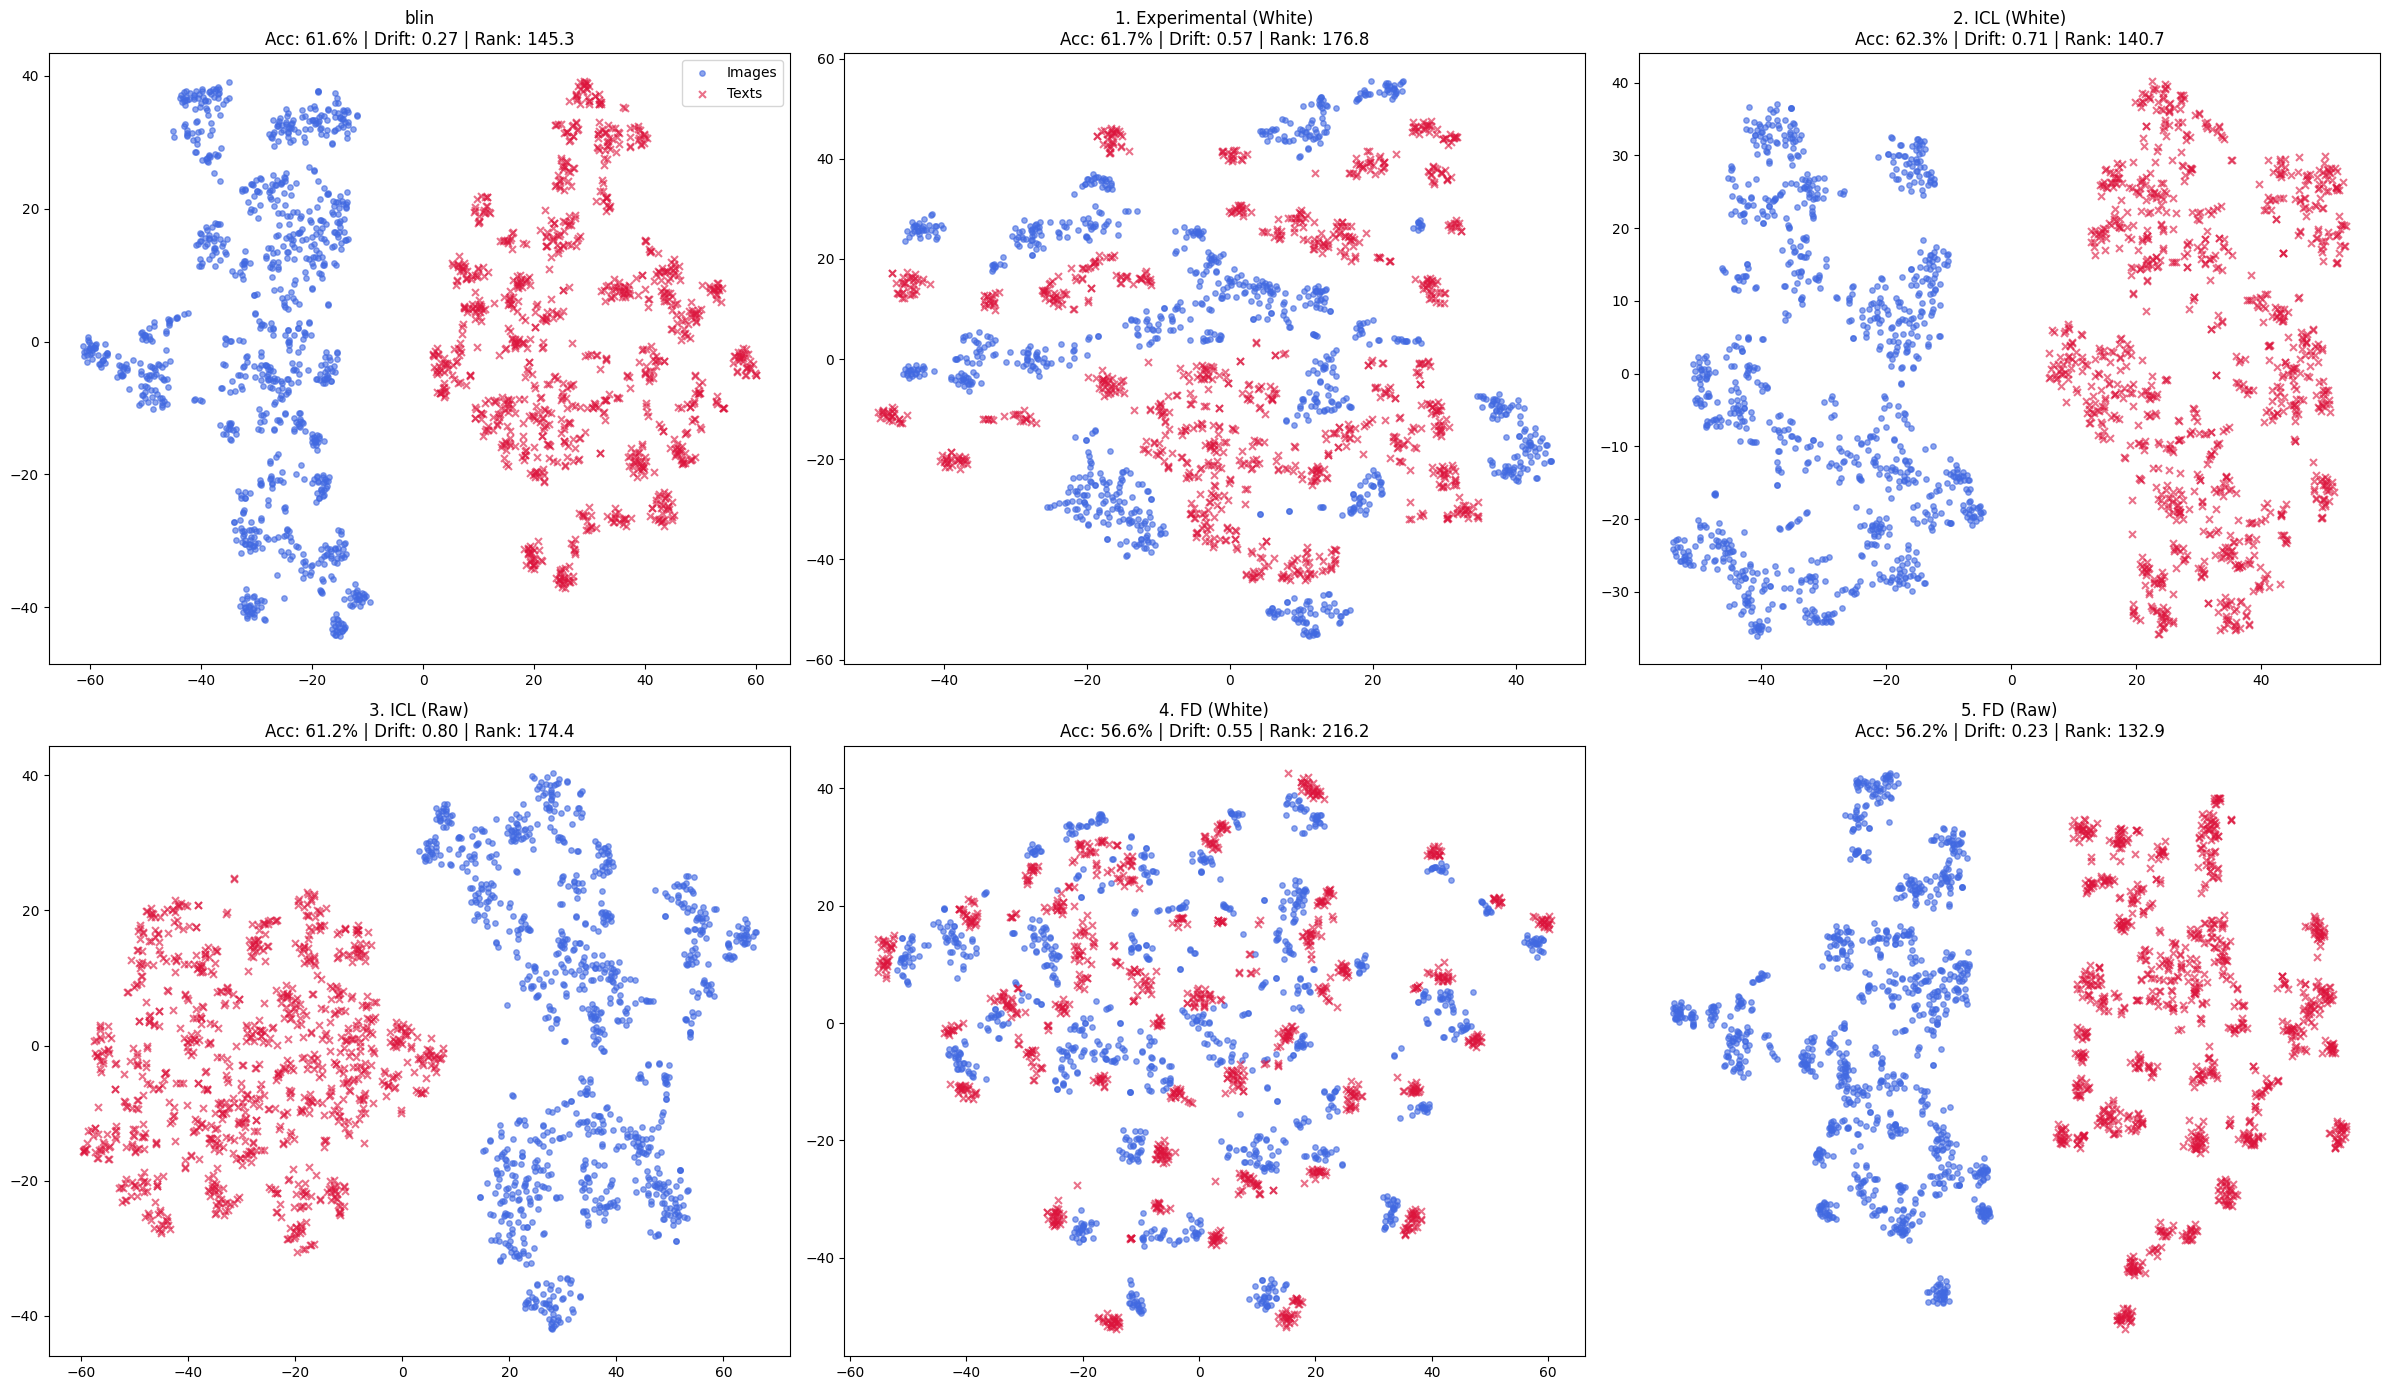


Model Name                | CIFAR Acc  | Align (Im-Tx)   | Drift (vs Raw)  | Eff. Rank 
-----------------------------------------------------------------------------------------------
blin                      | 61.60%     | 0.2152          | 0.2687          | 145.3     
1. Experimental (White)   | 61.70%     | 0.4329          | 0.5650          | 176.8     
2. ICL (White)            | 62.28%     | 0.2966          | 0.7091          | 140.7     
3. ICL (Raw)              | 61.18%     | 0.1596          | 0.8001          | 174.4     
4. FD (White)             | 56.64%     | 0.4269          | 0.5467          | 216.2     
5. FD (Raw)               | 56.17%     | 0.2743          | 0.2348          | 132.9     


In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm

# --- 1. Setup Models & Config ---
models_to_test = {
    "blin": student,
    "1. Experimental (White)": student_white, # The single run
    "2. ICL (White)": student_icl_white,      # Structure + Sphere
    "3. ICL (Raw)": student_icl_raw,          # Structure + Cone
    "4. FD (White)": student_fd_white,        # Content + Sphere
    "5. FD (Raw)": student_fd_raw             # Content + Cone
}

SAMPLE_LIMIT = 1000
results = {}

print(f"🔬 Starting Diagnostic on {len(models_to_test)} Models...")
print(f"   (Sampling exactly {SAMPLE_LIMIT} random points from COCO)")

# --- 2. The Analysis Loop ---
# Setup 2x3 Grid (last one empty)
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
axes = axes.flatten()

# Pre-fetch the random data ONCE so all models evaluate the exact same points
print("   📥 Fetching fixed subset of data...")
subset_imgs, subset_txts = [], []
subset_tv, subset_tt = [], []

iter_loader = iter(student_loader)
count = 0
while count < SAMPLE_LIMIT:
    try:
        imgs, tokens, t_v, t_t = next(iter_loader)
        subset_imgs.append(imgs)
        subset_txts.append(tokens)
        subset_tv.append(t_v)
        subset_tt.append(t_t)
        count += imgs.size(0)
    except StopIteration:
        break

# Concat and slice to exact limit
fixed_imgs = torch.cat(subset_imgs)[:SAMPLE_LIMIT].to(device)
fixed_txts = torch.cat(subset_txts)[:SAMPLE_LIMIT].to(device)
fixed_tv   = torch.cat(subset_tv)[:SAMPLE_LIMIT].to(device) # Raw Teacher Image
fixed_tt   = torch.cat(subset_tt)[:SAMPLE_LIMIT].to(device) # Raw Teacher Text

print("   ✅ Data loaded. Running Model Inference...")

for idx, (name, model) in enumerate(models_to_test.items()):
    model.eval()

    with torch.no_grad():
        # A. Inference (Batched to save VRAM if needed, but 1000 fits in L4 memory)
        # We process in one go since 1000 samples is small for an L4
        s_v, s_t, _ = model(images=fixed_imgs, texts=fixed_txts)

        # Normalize everything for fair Cosine Comparison
        s_v_norm = F.normalize(model.v_distill_head(s_v), p=2, dim=-1)
        s_t_norm = F.normalize(model.t_distill_head(s_t), p=2, dim=-1)
        t_v_norm = F.normalize(fixed_tv, p=2, dim=-1)

        # B. Calculate Metrics
        # 1. Modality Alignment (How close are Student Images to Student Text?)
        align_score = F.cosine_similarity(s_v_norm, s_t_norm).mean().item()

        # 2. Teacher Fidelity (How close is Student Image to Raw Teacher Image?)
        # Low score here = "New Geometry" (Good for Whitening)
        # High score here = "Mimicry" (Good for Standard Distillation)
        drift_score = 1.0 - F.cosine_similarity(s_v_norm, t_v_norm).mean().item()

        # 3. Isotropy (Effective Rank of Vision Branch)
        # Higher = More Spherical
        sv = torch.linalg.svdvals(s_v_norm)
        sv = sv / sv.sum()
        entropy = -torch.sum(sv * torch.log(sv + 1e-10))
        eff_rank = torch.exp(entropy).item()

        # 4. CIFAR Accuracy
        zsi_acc = evaluate_zsi(model, cifar_loader, text_descriptions, tokenizer_t, device)

        results[name] = {
            "Acc": zsi_acc,
            "Align": align_score,
            "Drift": drift_score,
            "Rank": eff_rank
        }

        # C. t-SNE Plotting
        print(f"   🎨 Generating t-SNE for {name}...")

        # Prepare for sklearn (CPU numpy)
        features = torch.cat([s_v_norm, s_t_norm], dim=0).cpu().numpy()

        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(features)

        ax = axes[idx]
        # Plot Images (Blue Dots)
        ax.scatter(embedded[:SAMPLE_LIMIT, 0], embedded[:SAMPLE_LIMIT, 1],
                   c='royalblue', alpha=0.6, s=15, label='Images')
        # Plot Texts (Red Crosses)
        ax.scatter(embedded[SAMPLE_LIMIT:, 0], embedded[SAMPLE_LIMIT:, 1],
                   c='crimson', marker='x', alpha=0.6, s=25, label='Texts')

        ax.set_title(f"{name}\nAcc: {zsi_acc*100:.1f}% | Drift: {drift_score:.2f} | Rank: {eff_rank:.1f}")
        if idx == 0: ax.legend()

# Formatting
axes[-1].axis('off') # Hide empty plot
plt.tight_layout()
plt.show()

# --- 3. Final Report Table ---
print("\n" + "="*95)
print(f"{'Model Name':<25} | {'CIFAR Acc':<10} | {'Align (Im-Tx)':<15} | {'Drift (vs Raw)':<15} | {'Eff. Rank':<10}")
print("-" * 95)
for name, res in results.items():
    print(f"{name:<25} | {res['Acc']*100:.2f}%     | {res['Align']:<15.4f} | {res['Drift']:<15.4f} | {res['Rank']:<10.1f}")
print("="*95)